In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler
from scipy.interpolate import griddata
import warnings
warnings.filterwarnings('ignore')

# Set matplotlib parameters for better plots
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10
sns.set_style("whitegrid")

In [47]:
def load_and_process_eeg_data():
    """Load EEG data and extract neural features"""
    
    # Load the dataset
    try:
        eeg_df = pd.read_csv(r"C:\Users\Me\data\combined_eeg_data.csv")
        print(f"✓ Loaded {len(eeg_df):,} EEG measurements")
        print(f"✓ Participants: {eeg_df['participant'].nunique()}")
        print(f"✓ Electrodes: {eeg_df['electrode'].nunique()}")
        print(f"✓ Frequencies: {eeg_df['frequency'].nunique()}")
        print(f"✓ Conditions: {list(eeg_df['condition'].unique())}")
    except FileNotFoundError:
        print("❌ Error: combined_eeg_data.csv not found")
        return None
    
    # Process complex coefficients
    def process_complex_coeff(coeff_str):
        """Extract magnitude and phase from complex coefficients"""
        try:
            if pd.isna(coeff_str):
                return np.nan, np.nan
            # Convert 'i' to 'j' for Python complex numbers
            coeff_str = str(coeff_str).strip('()')
            if 'i' in coeff_str and 'j' not in coeff_str:
                coeff_str = coeff_str.replace('i', 'j')
            coeff = complex(coeff_str)
            return abs(coeff), np.angle(coeff)  # magnitude and phase
        except:
            return np.nan, np.nan
    
    # Extract magnitude (neural activity strength) and phase
    complex_processed = eeg_df['coeff'].apply(process_complex_coeff)
    eeg_df['magnitude'] = [x[0] for x in complex_processed]
    eeg_df['phase'] = [x[1] for x in complex_processed]
    
    # Remove invalid data
    initial_rows = len(eeg_df)
    eeg_df = eeg_df.dropna(subset=['magnitude', 'phase'])
    print(f"✓ Processed complex coefficients")
    print(f"✓ Removed {initial_rows - len(eeg_df):,} invalid measurements")
    print(f"✓ Clean dataset: {len(eeg_df):,} measurements")
    
    return eeg_df

# Load and process data
eeg_df = load_and_process_eeg_data()

✓ Loaded 3,118,080 EEG measurements
✓ Participants: 14
✓ Electrodes: 32
✓ Frequencies: 58
✓ Conditions: ['GN', 'GS', 'UN', 'US']
✓ Processed complex coefficients
✓ Removed 0 invalid measurements
✓ Clean dataset: 3,118,080 measurements


In [48]:
def create_feature_matrix(eeg_df):
    """Create feature matrix for LDA analysis"""
    
    # Create electrode-frequency feature combinations
    eeg_df['electrode_freq'] = (
        eeg_df['electrode'].astype(str) + '_' + 
        eeg_df['frequency'].astype(str) + 'Hz'
    )
    
    # Create pivot table: trials × electrode-frequency features
    # Use magnitude as it represents general brain response strength
    feature_matrix = eeg_df.pivot_table(
        index=['participant', 'trial', 'condition'],
        columns='electrode_freq',
        values='magnitude',  # Focus on neural activity strength
        aggfunc='mean'
    ).reset_index()
    
    # Get feature column names
    feature_cols = [col for col in feature_matrix.columns 
                   if col not in ['participant', 'trial', 'condition']]
    
    # Fill missing values with column means
    feature_matrix[feature_cols] = feature_matrix[feature_cols].fillna(
        feature_matrix[feature_cols].mean()
    )
    
    print(f"✓ Feature matrix created: {feature_matrix.shape}")
    print(f"✓ Neural features: {len(feature_cols)}")
    print(f"✓ Total trials: {len(feature_matrix)}")
    
    return feature_matrix, feature_cols

# Create feature matrix
if eeg_df is not None:
    feature_matrix, feature_cols = create_feature_matrix(eeg_df)

✓ Feature matrix created: (1680, 1859)
✓ Neural features: 1856
✓ Total trials: 1680


In [49]:
def apply_lda_components(feature_matrix, feature_cols):
    """Apply LDA to find discriminant components for optimal condition separation"""
    
    print(f"\n🔄 APPLYING LDA FOR CONDITION DISCRIMINATION")
    print("-" * 45)
    
    # Prepare data
    X = feature_matrix[feature_cols].values
    y = feature_matrix['condition'].values
    
    # LDA can find at most min(n_features, n_classes-1) components
    n_classes = len(np.unique(y))
    max_components = min(X.shape[1], n_classes - 1)
    n_components = min(3, max_components)  # Use 3 or maximum possible
    
    print(f"Original dimensionality: {X.shape[1]} features → {n_components} discriminant components")
    print(f"Number of conditions: {n_classes}")
    print(f"Maximum possible components: {max_components}")
    print(f"Using {n_components} components for analysis")
    
    # Standardize features (recommended for LDA)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    print(f"✓ Features standardized")
    
    # Apply LDA
    lda = LinearDiscriminantAnalysis(n_components=n_components)
    X_lda = lda.fit_transform(X_scaled, y)
    
    # Calculate explained variance ratio (proportion of between-class variance)
    explained_var_ratio = lda.explained_variance_ratio_
    total_explained_var = explained_var_ratio.sum()
    cumulative_var = np.cumsum(explained_var_ratio)
    
    print(f"✓ LDA transformation complete")
    for i in range(n_components):
        print(f"  LD{i+1}: {explained_var_ratio[i]:.1%} discriminative power")
    print(f"  Total discriminative variance captured: {total_explained_var:.1%}")
    
    # Store results
    results = {
        'model': lda,
        'data': X_lda,
        'scaler': scaler,
        'explained_variance_ratio': explained_var_ratio,
        'total_explained_variance': total_explained_var,
        'cumulative_variance': cumulative_var,
        'original_features': X.shape[1],
        'n_components': n_components
    }
    
    return results, X, y

# Apply LDA
if 'feature_matrix' in locals():
    lda_results, X_original, y_conditions = apply_lda_components(feature_matrix, feature_cols)


🔄 APPLYING LDA FOR CONDITION DISCRIMINATION
---------------------------------------------
Original dimensionality: 1856 features → 3 discriminant components
Number of conditions: 4
Maximum possible components: 3
Using 3 components for analysis
✓ Features standardized
✓ LDA transformation complete
  LD1: 36.4% discriminative power
  LD2: 34.2% discriminative power
  LD3: 29.4% discriminative power
  Total discriminative variance captured: 100.0%


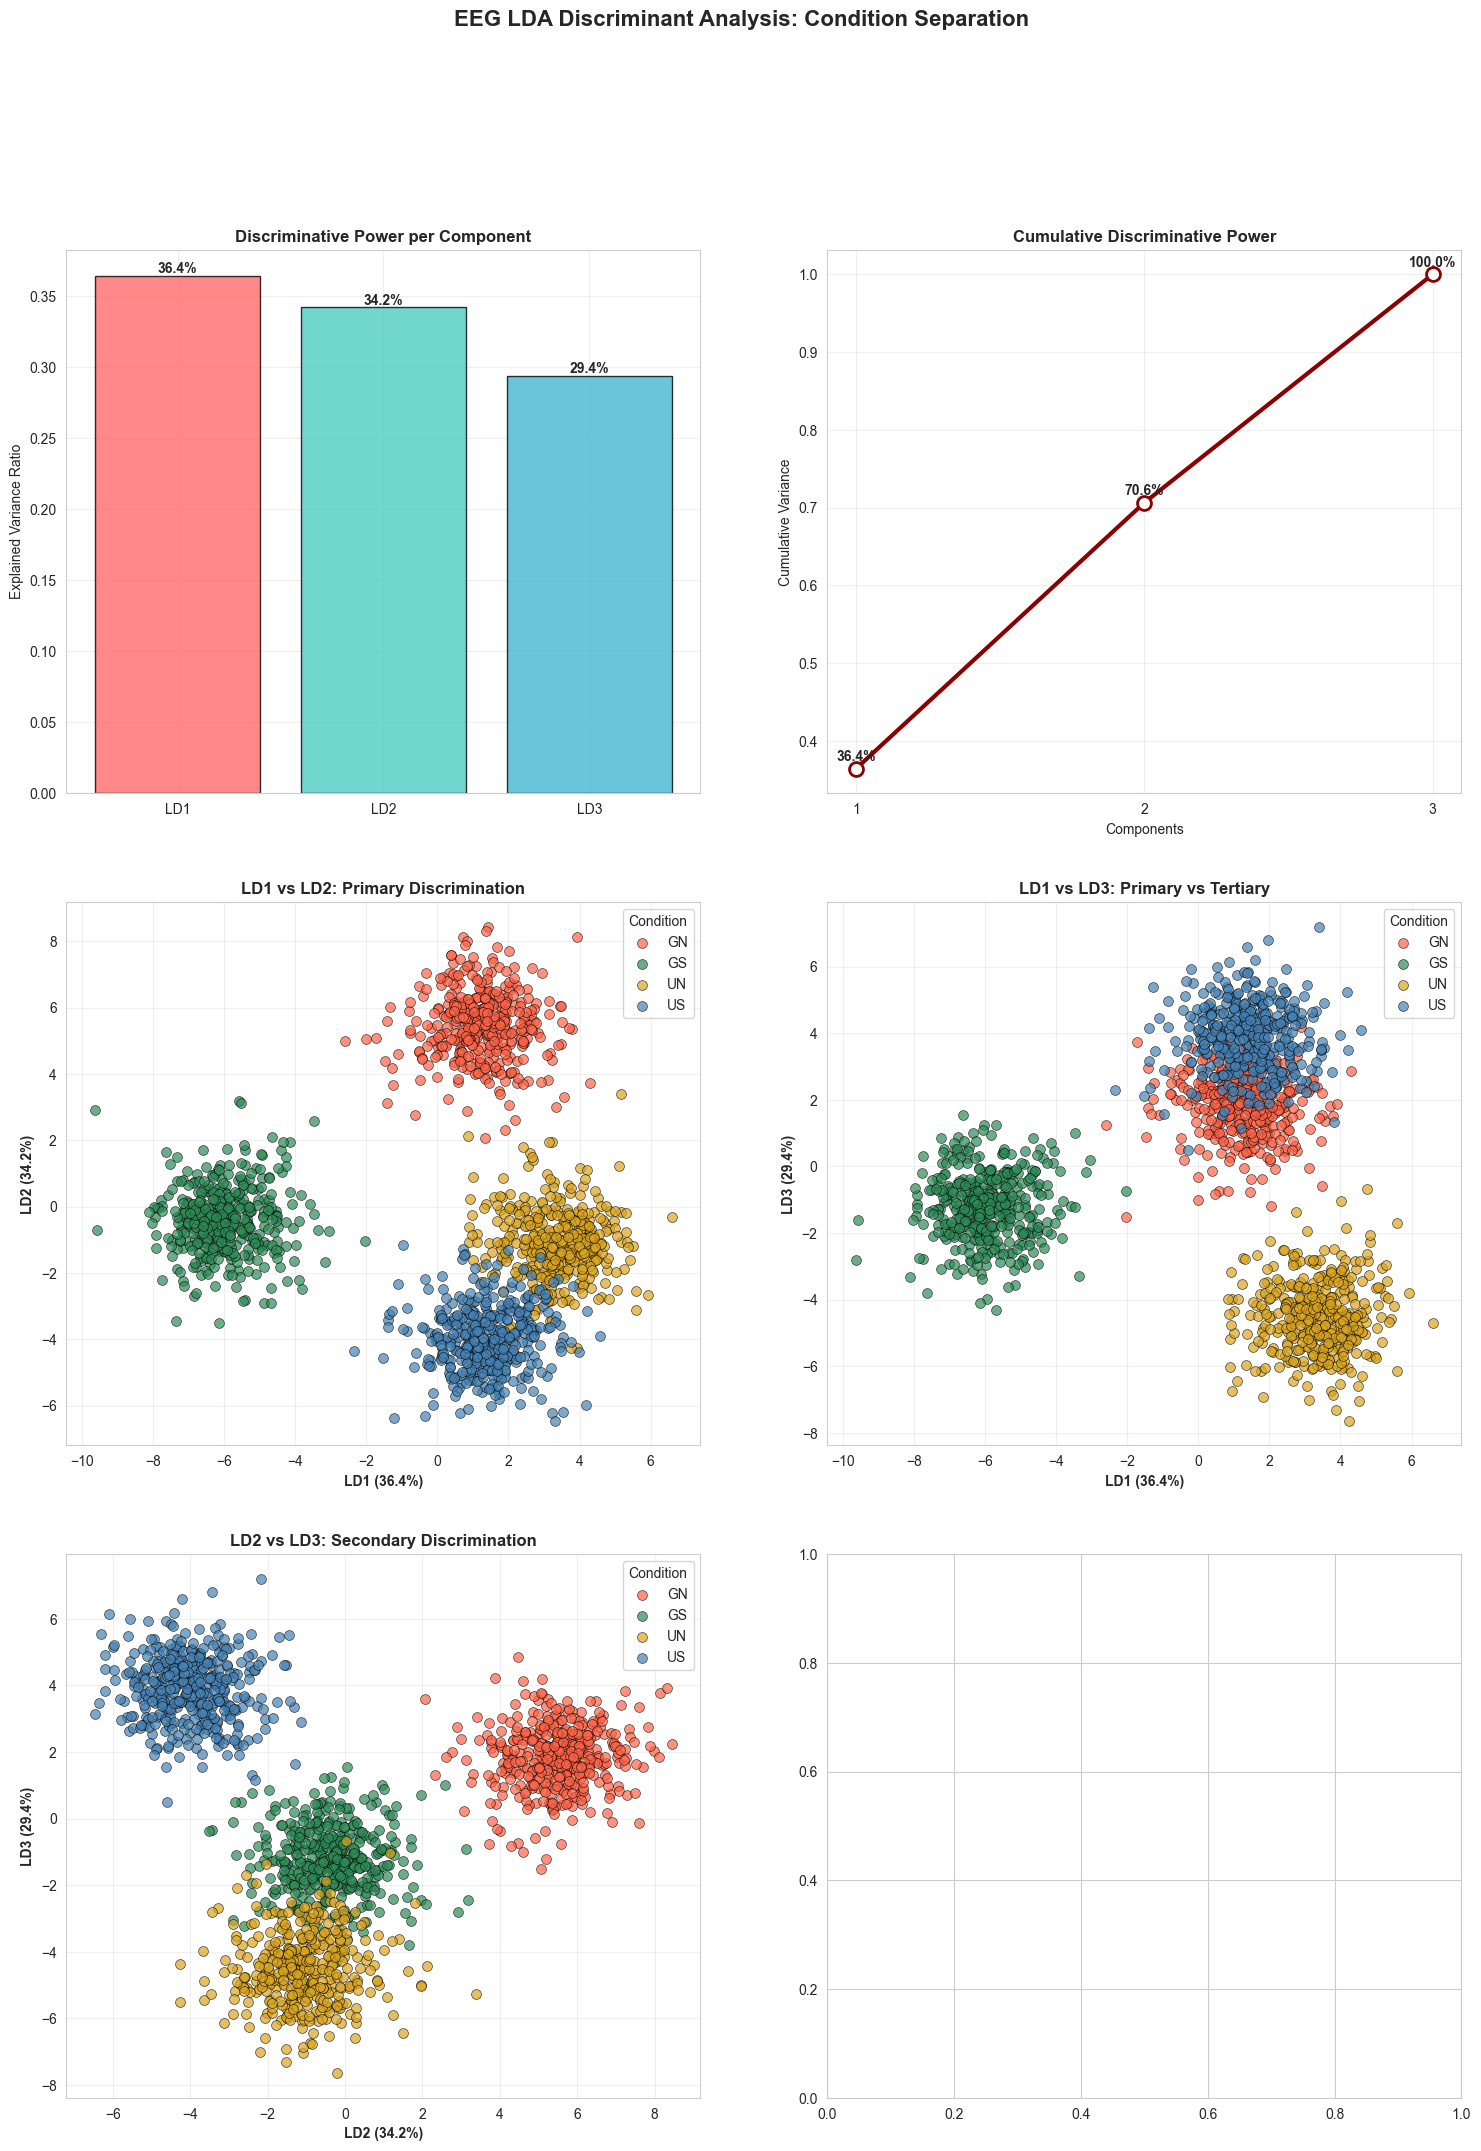

In [50]:
def visualize_lda_components(results, y_conditions):
    """Create comprehensive visualization of LDA results"""
    
    # Color mapping for conditions  
    colors = {'GS': '#2E8B57', 'GN': '#FF6347', 'US': '#4682B4', 'UN': '#DAA520'}
    condition_names = {'GS': 'Grammatical Sensible', 'GN': 'Grammatical Nonsense', 
                      'US': 'Ungrammatical Sensible', 'UN': 'Ungrammatical Nonsense'}
    
    X_lda = results['data']
    explained_var = results['explained_variance_ratio']
    n_components = results['n_components']
    
    # Create visualization - adjust layout based on number of components
    if n_components == 3:
        fig, axes = plt.subplots(3, 2, figsize=(18, 24))


    fig.suptitle('EEG LDA Discriminant Analysis: Condition Separation', fontsize=16, fontweight='bold')
    
    # 1. Explained Variance by Component
    ax = axes[0, 0]
    comp_labels = [f'LD{i+1}' for i in range(n_components)]
    bars = ax.bar(comp_labels, explained_var, 
                  color=['#FF6B6B', '#4ECDC4', '#45B7D1'][:n_components], 
                  alpha=0.8, edgecolor='black')
    ax.set_title('Discriminative Power per Component', fontweight='bold')
    ax.set_ylabel('Explained Variance Ratio')
    ax.grid(True, alpha=0.3)
    
    for bar, var in zip(bars, explained_var):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.002, 
                f'{var:.1%}', ha='center', fontweight='bold')
    
    # 2. Cumulative Variance
    ax = axes[0, 1]
    cumulative_var = results['cumulative_variance']
    ax.plot(range(1, n_components+1), cumulative_var, 'o-', linewidth=3, markersize=10, 
            color='darkred', markerfacecolor='white', markeredgewidth=2)
    ax.set_title('Cumulative Discriminative Power', fontweight='bold')
    ax.set_xlabel('Components')
    ax.set_ylabel('Cumulative Variance')
    ax.set_xticks(range(1, n_components+1))
    ax.grid(True, alpha=0.3)
    
    for i, var in enumerate(cumulative_var):
        ax.text(i+1, var + 0.01, f'{var:.1%}', ha='center', fontweight='bold')
    

    
    # Scatter plots for component pairs
    if n_components >= 2:
        # LD1 vs LD2
        ax = axes[1, 0]
        for condition in np.unique(y_conditions):
            mask = y_conditions == condition
            ax.scatter(X_lda[mask, 0], X_lda[mask, 1], 
                       c=colors[condition], label=f'{condition}', 
                       alpha=0.7, s=50, edgecolors='black', linewidth=0.5)
        
        ax.set_xlabel(f'LD1 ({explained_var[0]:.1%})', fontweight='bold')
        ax.set_ylabel(f'LD2 ({explained_var[1]:.1%})', fontweight='bold')
        ax.set_title('LD1 vs LD2: Primary Discrimination', fontweight='bold')
        ax.legend(title='Condition')
        ax.grid(True, alpha=0.3)
    
    if n_components == 3:
        # LD1 vs LD3
        ax = axes[1, 1]
        for condition in np.unique(y_conditions):
            mask = y_conditions == condition
            ax.scatter(X_lda[mask, 0], X_lda[mask, 2], 
                       c=colors[condition], label=f'{condition}', 
                       alpha=0.7, s=50, edgecolors='black', linewidth=0.5)
        
        ax.set_xlabel(f'LD1 ({explained_var[0]:.1%})', fontweight='bold')
        ax.set_ylabel(f'LD3 ({explained_var[2]:.1%})', fontweight='bold')
        ax.set_title('LD1 vs LD3: Primary vs Tertiary', fontweight='bold')
        ax.legend(title='Condition')
        ax.grid(True, alpha=0.3)
        
        # LD2 vs LD3
        ax = axes[2, 0]
        for condition in np.unique(y_conditions):
            mask = y_conditions == condition
            ax.scatter(X_lda[mask, 1], X_lda[mask, 2], 
                       c=colors[condition], label=f'{condition}', 
                       alpha=0.7, s=50, edgecolors='black', linewidth=0.5)
        
        ax.set_xlabel(f'LD2 ({explained_var[1]:.1%})', fontweight='bold')
        ax.set_ylabel(f'LD3 ({explained_var[2]:.1%})', fontweight='bold')
        ax.set_title('LD2 vs LD3: Secondary Discrimination', fontweight='bold')
        ax.legend(title='Condition')
        ax.grid(True, alpha=0.3)


# Create visualizations
if 'lda_results' in locals():
    visualize_lda_components(lda_results, y_conditions)

In [51]:
def analyze_component_features(results, feature_cols):
    """Analyze which features contribute most to each discriminant component"""
    
    print(f"\n🔬 DISCRIMINANT COMPONENT FEATURE ANALYSIS")
    print("-" * 45)
    
    # Get discriminant function coefficients (scalings)
    scalings = results['model'].scalings_
    n_components = results['n_components']
    
    for i in range(n_components):
        print(f"\n--- LD{i+1} ({results['explained_variance_ratio'][i]:.1%} discriminative power) ---")
        
        # Get feature loadings (discriminant coefficients)
        loadings = scalings[:, i]
        feature_importance = pd.DataFrame({
            'feature': feature_cols,
            'loading': loadings,
            'abs_loading': np.abs(loadings)
        }).sort_values('abs_loading', ascending=False)
        
        # Show top 8 contributing features
        print("Top discriminating electrode-frequency combinations:")
        for j, (_, row) in enumerate(feature_importance.head(8).iterrows()):
            electrode, freq = row['feature'].split('_')
            freq = freq.replace('Hz', '')
            print(f"  {j+1}. {electrode:4s} @ {freq:>6s}Hz  (coefficient: {row['loading']:+.3f})")
    
    return scalings

# Analyze components
if 'lda_results' in locals():
    discriminant_coefficients = analyze_component_features(lda_results, feature_cols)


🔬 DISCRIMINANT COMPONENT FEATURE ANALYSIS
---------------------------------------------

--- LD1 (36.4% discriminative power) ---
Top discriminating electrode-frequency combinations:
  1. PO10 @  3.125Hz  (coefficient: +5.806)
  2. FC6  @ 2.47395833333333Hz  (coefficient: -5.353)
  3. T8   @ 2.40885416666667Hz  (coefficient: -4.894)
  4. T8   @  3.125Hz  (coefficient: +4.404)
  5. FC1  @ 1.69270833333333Hz  (coefficient: +4.189)
  6. O2   @ 2.86458333333333Hz  (coefficient: +3.955)
  7. O2   @ 3.19010416666667Hz  (coefficient: +3.883)
  8. FC1  @ 1.43229166666667Hz  (coefficient: +3.820)

--- LD2 (34.2% discriminative power) ---
Top discriminating electrode-frequency combinations:
  1. PO10 @ 3.3203125Hz  (coefficient: -4.782)
  2. Cz   @ 2.9296875Hz  (coefficient: -4.544)
  3. Oz   @ 2.66927083333333Hz  (coefficient: -4.430)
  4. CP2  @ 3.7109375Hz  (coefficient: +4.327)
  5. O1   @ 0.78125Hz  (coefficient: -4.046)
  6. PO10 @ 2.34375Hz  (coefficient: -3.938)
  7. FC2  @ 3.3854166666

In [52]:
def analyze_actual_electrodes_and_create_lda_maps(results, feature_cols, eeg_df):
    """Analyze actual electrodes and create topographic visualizations for LDA discriminant patterns"""
    
    print(f"\n🔍 EEG LDA TOPOGRAPHIC MAPPING - DISCRIMINANT PATTERN ANALYSIS")
    print("-" * 75)
    
    # Extract actual electrodes from your data
    actual_electrodes = sorted(set(feature.split('_')[0] for feature in feature_cols))
    
    print(f"✓ Found {len(actual_electrodes)} electrodes in your data:")
    print(f"  {actual_electrodes}")
    
    # Comprehensive 10-20 system reference (with precise anatomical positions)
    electrode_positions = {
        # Frontal Region
        'Fp1': (-0.35, 0.85), 'Fp2': (0.35, 0.85), 
        'F7': (-0.75, 0.55), 'F3': (-0.4, 0.6), 'Fz': (0.0, 0.65), 'F4': (0.4, 0.6), 'F8': (0.75, 0.55),
        
        # Fronto-Central Region
        'FC5': (-0.6, 0.35), 'FC1': (-0.2, 0.4), 'FC2': (0.2, 0.4), 'FC6': (0.6, 0.35),
        
        # Central Region
        'T7': (-0.85, 0.0), 'C3': (-0.4, 0.0), 'Cz': (0.0, 0.0), 'C4': (0.4, 0.0), 'T8': (0.85, 0.0),
        
        # Central-Parietal Region
        'CP5': (-0.6, -0.35), 'CP1': (-0.2, -0.4), 'CP2': (0.2, -0.4), 'CP6': (0.6, -0.35),
        
        # Parietal Region
        'P7': (-0.75, -0.55), 'P3': (-0.4, -0.6), 'Pz': (0.0, -0.65), 'P4': (0.4, -0.6), 'P8': (0.75, -0.55),
        
        # Parieto-Occipital Region
        'PO9': (-0.75, -0.75), 'PO10': (0.75, -0.75),
        
        # Temporal-Parietal Region
        'TP9': (-0.9, -0.3), 'TP10': (0.9, -0.3),
        
        # Occipital Region
        'O1': (-0.35, -0.85), 'Oz': (0.0, -0.9), 'O2': (0.35, -0.85)
    }
    
    # Verify all your electrodes have positions defined
    missing = [e for e in actual_electrodes if e not in electrode_positions]
    if missing:
        print(f"❌ ERROR: {len(missing)} electrodes missing position definitions:")
        print(f"   {missing}")
        return None
    else:
        print(f"✓ All {len(actual_electrodes)} electrodes have anatomically accurate position definitions")
    
    # Calculate discriminant coefficients per electrode (averaged across frequencies)
    scalings = results['model'].scalings_
    n_components = results['n_components']
    electrode_coefficients = {}
    
    for ld_idx in range(n_components):
        electrode_coefficients[ld_idx] = {}
        for i, feature in enumerate(feature_cols):
            electrode = feature.split('_')[0]
            if electrode not in electrode_coefficients[ld_idx]:
                electrode_coefficients[ld_idx][electrode] = []
            electrode_coefficients[ld_idx][electrode].append(scalings[i, ld_idx])
        
        # Calculate mean coefficient per electrode
        for electrode in electrode_coefficients[ld_idx]:
            electrode_coefficients[ld_idx][electrode] = np.mean(electrode_coefficients[ld_idx][electrode])
    
    # Create visualizations
    print(f"\n🎨 GENERATING DISCRIMINANT PATTERN TOPOGRAPHIC MAPS")
    print("-" * 55)
    
    # Determine global color scale for consistent visualization across components
    all_coefficients = []
    for ld_idx in range(n_components):
        all_coefficients.extend(electrode_coefficients[ld_idx].values())
    
    global_vmax = max(abs(min(all_coefficients)), abs(max(all_coefficients)))
    global_vmax = global_vmax * 1.05  # Add 5% padding
    
    # Define regions based on electrode positions
    frontal = ['Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8']
    central = ['FC5', 'FC1', 'FC2', 'FC6', 'T7', 'C3', 'Cz', 'C4', 'T8']
    parietal = ['CP5', 'CP1', 'CP2', 'CP6', 'P7', 'P3', 'Pz', 'P4', 'P8', 'TP9', 'TP10']
    occipital = ['PO9', 'PO10', 'O1', 'Oz', 'O2']
    
    # Create separate topographic maps for each discriminant component
    for ld_idx in range(n_components):
        fig, ax = plt.subplots(figsize=(10, 8))
        
        # Prepare data
        x_coords = []
        y_coords = []
        coefficients = []
        labels = []
        
        for electrode in actual_electrodes:
            x, y = electrode_positions[electrode]
            x_coords.append(x)
            y_coords.append(y)
            coefficients.append(electrode_coefficients[ld_idx][electrode])
            labels.append(electrode)
        
        x_coords = np.array(x_coords)
        y_coords = np.array(y_coords)
        coefficients = np.array(coefficients)
        
        # Create higher resolution grid for smoother interpolation
        resolution = 100
        xi = np.linspace(-1.1, 1.1, resolution)
        yi = np.linspace(-1.1, 1.1, resolution)
        Xi, Yi = np.meshgrid(xi, yi)
        
        # Create anatomically accurate head mask
        mask = (Xi**2/0.9 + Yi**2) <= 1.15 
        
        # Interpolate using robust method
        from scipy.interpolate import RBFInterpolator
        try:
            interpolator = RBFInterpolator(
                np.column_stack((x_coords, y_coords)), 
                coefficients,
                kernel='thin_plate_spline',
                epsilon=0.1
            )
            Zi = interpolator(np.column_stack((Xi.flatten(), Yi.flatten())))
            Zi = Zi.reshape(Xi.shape)
        except:
            # Fallback to griddata
            from scipy.interpolate import griddata
            Zi = griddata((x_coords, y_coords), coefficients, (Xi, Yi), 
                         method='cubic', fill_value=0)
        
        # Apply head mask
        Zi[~mask] = np.nan
        
        # Plot topographic map
        im = ax.contourf(Xi, Yi, Zi, levels=30, cmap='RdBu_r', 
                        vmin=-global_vmax, vmax=global_vmax, extend='both')
        
        # Add contour lines
        contours = ax.contour(Xi, Yi, Zi, levels=10, colors='k', linewidths=0.5, alpha=0.3,
                             vmin=-global_vmax, vmax=global_vmax)
        plt.clabel(contours, inline=True, fontsize=7, fmt='%1.2f')
        
        # Add electrode positions
        scatter = ax.scatter(x_coords, y_coords, c=coefficients, 
                           cmap='RdBu_r', s=120, edgecolors='k', 
                           linewidth=1.2, vmin=-global_vmax, vmax=global_vmax, zorder=5)
        
        # Smart electrode labeling
        for i, label in enumerate(labels):
            x, y = x_coords[i], y_coords[i]
            
            if label in ['Fp1', 'Fp2', 'O1', 'O2']:
                offset = (0, -15) if y < 0 else (0, 15)
            elif label in ['T7', 'T8', 'TP9', 'TP10']:
                offset = (-15, 0) if x < 0 else (15, 0)
            else:
                offset = (5, 5)
            
            ax.annotate(label, (x, y), xytext=offset, textcoords='offset points',
                       ha='center', va='center', fontsize=9, fontweight='bold',
                       color='k', bbox=dict(boxstyle='round,pad=0.2', 
                                           facecolor='white', alpha=0.85, edgecolor='gray'))
        
        # Draw head outline and features
        head = plt.Circle((0, 0), 1, fill=False, linewidth=2.5, color='k', alpha=0.9)
        ax.add_patch(head)
        
        # Nose
        ax.plot([0, 0], [1.0, 1.18], 'k-', linewidth=3.5)
        ax.plot([-0.08, 0.08], [1.12, 1.12], 'k-', linewidth=2.2)
        ax.plot([0, -0.05], [1.12, 1.05], 'k-', linewidth=1.5)
        ax.plot([0, 0.05], [1.12, 1.05], 'k-', linewidth=1.5)
        
        # Ears
        ear_l = plt.Polygon([(-1.05, 0.1), (-0.95, 0.15), (-0.9, 0.05), (-0.95, -0.05), (-1.05, -0.05)],
                          fill=False, linewidth=1.8, color='k')
        ear_r = plt.Polygon([(1.05, 0.1), (0.95, 0.15), (0.9, 0.05), (0.95, -0.05), (1.05, -0.05)],
                          fill=False, linewidth=1.8, color='k')
        ax.add_patch(ear_l)
        ax.add_patch(ear_r)
        
        # Grid lines
        for r in [0.25, 0.5, 0.75]:
            circle = plt.Circle((0, 0), r, fill=False, linestyle=':', 
                              color='gray', alpha=0.4, linewidth=1)
            ax.add_patch(circle)
        
        # Formatting
        variance_pct = results['explained_variance_ratio'][ld_idx]
        ax.set_title(f'LD{ld_idx+1} Discriminant Pattern\n({variance_pct:.1%} of Discriminative Power)', 
                    fontweight='bold', fontsize=14)
        ax.set_xlim(-1.35, 1.35)
        ax.set_ylim(-1.35, 1.35)
        ax.set_aspect('equal')
        ax.axis('off')
        
        # Add colorbar
        cbar = plt.colorbar(im, ax=ax, shrink=0.8, aspect=20)
        cbar.set_label('Discriminant Coefficient', fontsize=12, fontweight='bold')
        cbar.ax.axvline(x=0, color='k', linestyle='-', linewidth=1.2)
        
        plt.tight_layout()
        plt.show()
    
    # Create electrode contribution analysis
    fig, axes = plt.subplots(1, n_components, figsize=(6*n_components, 8))
    if n_components == 1:
        axes = [axes]
        
    fig.suptitle('EEG LDA Analysis: Electrode Discriminant Contributions', 
                 fontsize=16, fontweight='bold')
    
    # Region colors for shading
    region_colors = {
        'Frontal': (0.9, 0.95, 1.0, 0.3),
        'Central': (0.95, 0.95, 0.95, 0.3),
        'Parietal': (0.9, 1.0, 0.9, 0.3),
        'Occipital': (1.0, 0.9, 0.9, 0.3)
    }
    
    for ld_idx in range(n_components):
        ax = axes[ld_idx]
        
        # Get sorted electrodes by absolute coefficient
        sorted_electrodes = sorted(electrode_coefficients[ld_idx].items(), 
                                 key=lambda x: abs(x[1]), reverse=True)
        
        electrodes = [item[0] for item in sorted_electrodes]
        coeffs = [item[1] for item in sorted_electrodes]
        
        # Create diverging color map
        colors = []
        for coeff in coeffs:
            if coeff < 0:
                intensity = min(1.0, abs(coeff)/global_vmax)
                colors.append((1.0, 1.0-intensity*0.7, 1.0-intensity*0.7))
            else:
                intensity = min(1.0, abs(coeff)/global_vmax)
                colors.append((1.0-intensity*0.7, 1.0-intensity*0.7, 1.0))
        
        # Create horizontal bar chart
        y_pos = np.arange(len(electrodes))
        bars = ax.barh(y_pos, coeffs, color=colors, edgecolor='k', linewidth=0.7)
        
        # Add value labels
        for i, v in enumerate(coeffs):
            if abs(v) > global_vmax * 0.1:
                ax.text(v + (0.05 * np.sign(v) * global_vmax), i, f'{v:.3f}', 
                       va='center', ha='left' if v > 0 else 'right', fontsize=8)
        
        # Add region shading
        for i, electrode in enumerate(electrodes):
            if electrode in frontal:
                ax.axhspan(i-0.4, i+0.4, facecolor=region_colors['Frontal'], alpha=0.6)
            elif electrode in central:
                ax.axhspan(i-0.4, i+0.4, facecolor=region_colors['Central'], alpha=0.6)
            elif electrode in parietal:
                ax.axhspan(i-0.4, i+0.4, facecolor=region_colors['Parietal'], alpha=0.6)
            elif electrode in occipital:
                ax.axhspan(i-0.4, i+0.4, facecolor=region_colors['Occipital'], alpha=0.6)
        
        # Formatting
        ax.set_yticks(y_pos)
        ax.set_yticklabels(electrodes)
        ax.set_xlabel('Discriminant Coefficient', fontweight='bold')
        variance_pct = results['explained_variance_ratio'][ld_idx]
        ax.set_title(f'LD{ld_idx+1} Electrode Contributions\n({variance_pct:.1%} Power)', 
                    fontweight='bold', fontsize=12)
        ax.grid(True, alpha=0.3, linestyle='--')
        ax.axvline(x=0, color='k', linestyle='-', linewidth=1.5)
        ax.set_xlim(-global_vmax*1.15, global_vmax*1.15)
        
        # Add region legend to first subplot
        if ld_idx == 0:
            from matplotlib.patches import Patch
            legend_elements = [
                Patch(facecolor=region_colors['Frontal'], edgecolor='k', alpha=0.6, label='Frontal'),
                Patch(facecolor=region_colors['Central'], edgecolor='k', alpha=0.6, label='Central'),
                Patch(facecolor=region_colors['Parietal'], edgecolor='k', alpha=0.6, label='Parietal'),
                Patch(facecolor=region_colors['Occipital'], edgecolor='k', alpha=0.6, label='Occipital')
            ]
            ax.legend(handles=legend_elements, loc='lower right', fontsize=9, 
                     title="Cortical Regions", title_fontsize=10)
    
    plt.tight_layout()
    plt.savefig('eeg_lda_electrode_discriminant_contributions.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print detailed analysis
    print(f"\n🧠 NEUROANATOMICAL INTERPRETATION OF DISCRIMINANT COMPONENTS")
    print("=" * 70)
    
    for ld_idx in range(n_components):
        print(f"\nLD{ld_idx+1} ({results['explained_variance_ratio'][ld_idx]:.1%} discriminative power):")
        
        # Identify dominant regions
        region_sums = {'Frontal': 0, 'Central': 0, 'Parietal': 0, 'Occipital': 0}
        region_counts = {k: 0 for k in region_sums}
        
        for electrode, coeff in electrode_coefficients[ld_idx].items():
            abs_coeff = abs(coeff)
            if electrode in frontal:
                region_sums['Frontal'] += abs_coeff
                region_counts['Frontal'] += 1
            elif electrode in central:
                region_sums['Central'] += abs_coeff
                region_counts['Central'] += 1
            elif electrode in parietal:
                region_sums['Parietal'] += abs_coeff
                region_counts['Parietal'] += 1
            elif electrode in occipital:
                region_sums['Occipital'] += abs_coeff
                region_counts['Occipital'] += 1
        
        # Calculate average coefficient per region
        region_averages = {k: region_sums[k]/region_counts[k] if region_counts[k] > 0 else 0 
                          for k in region_sums}
        
        dominant_region = max(region_averages, key=region_averages.get)
        
        # Determine pattern type
        polarity = "biphasic"
        if all(coeff >= 0 for coeff in electrode_coefficients[ld_idx].values()):
            polarity = "positive-dominant"
        elif all(coeff <= 0 for coeff in electrode_coefficients[ld_idx].values()):
            polarity = "negative-dominant"
        
        print(f"  Most discriminative region: {dominant_region}")
        print(f"  Pattern type: {polarity}")
        
        print(f"\n  Strongest discriminating electrodes:")
        sorted_electrodes = sorted(electrode_coefficients[ld_idx].items(), 
                                 key=lambda x: abs(x[1]), reverse=True)
        for i, (electrode, coeff) in enumerate(sorted_electrodes[:6]):
            region = ""
            if electrode in frontal: region = " (Frontal)"
            elif electrode in central: region = " (Central)"
            elif electrode in parietal: region = " (Parietal)"
            elif electrode in occipital: region = " (Occipital)"
                
            print(f"    {i+1:2d}. {electrode:6s}: {coeff:+.4f}{region}")
    
    return electrode_coefficients, actual_electrodes

# Analyze actual electrodes and create visualizations



🔍 EEG LDA TOPOGRAPHIC MAPPING - DISCRIMINANT PATTERN ANALYSIS
---------------------------------------------------------------------------
✓ Found 32 electrodes in your data:
  ['C3', 'C4', 'CP1', 'CP2', 'CP5', 'CP6', 'Cz', 'F3', 'F4', 'F7', 'F8', 'FC1', 'FC2', 'FC5', 'FC6', 'Fp1', 'Fp2', 'Fz', 'O1', 'O2', 'Oz', 'P3', 'P4', 'P7', 'P8', 'PO10', 'PO9', 'Pz', 'T7', 'T8', 'TP10', 'TP9']
✓ All 32 electrodes have anatomically accurate position definitions

🎨 GENERATING DISCRIMINANT PATTERN TOPOGRAPHIC MAPS
-------------------------------------------------------


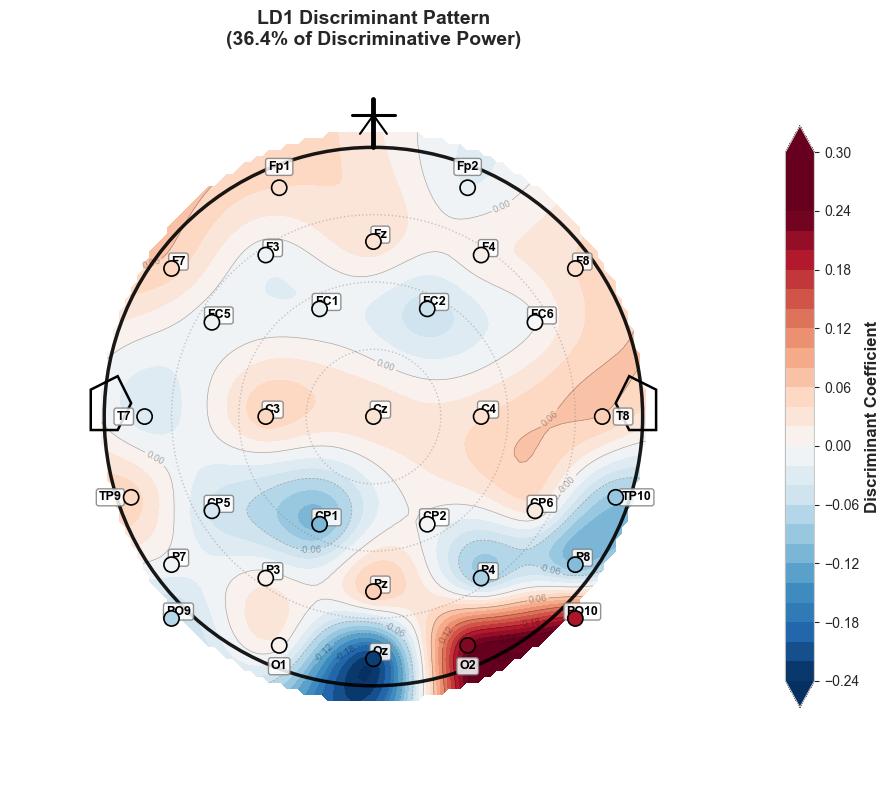

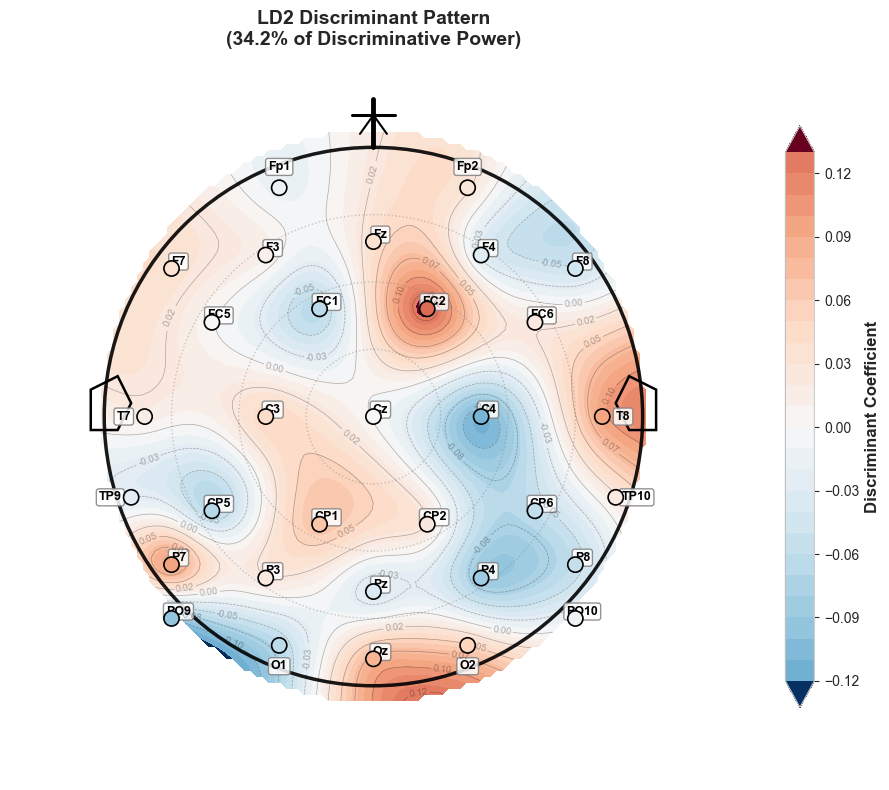

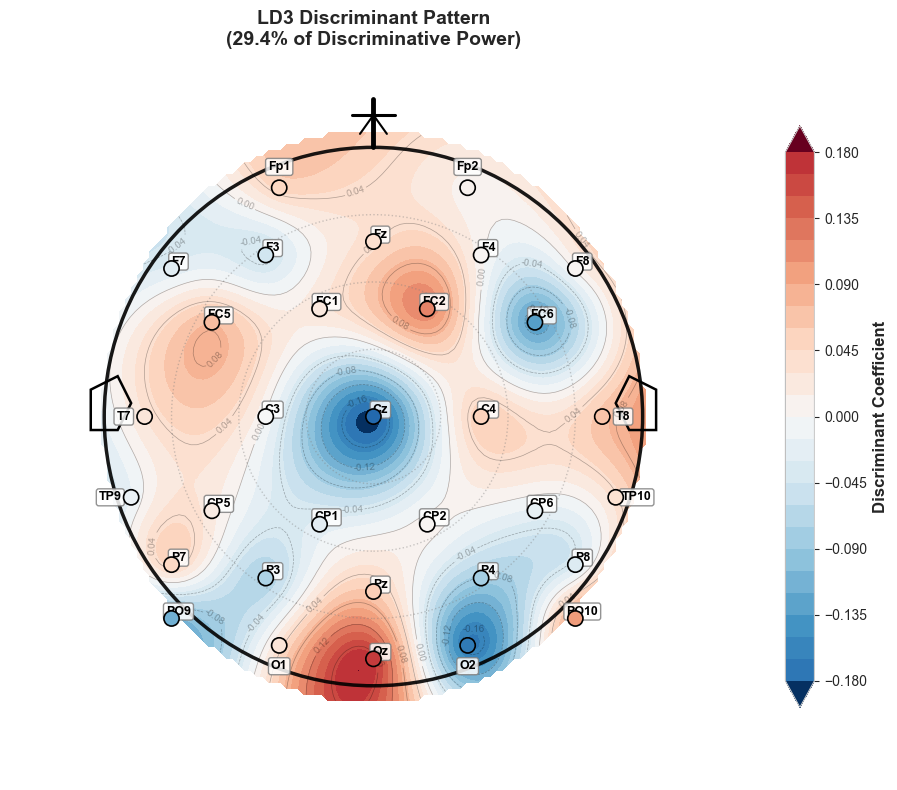

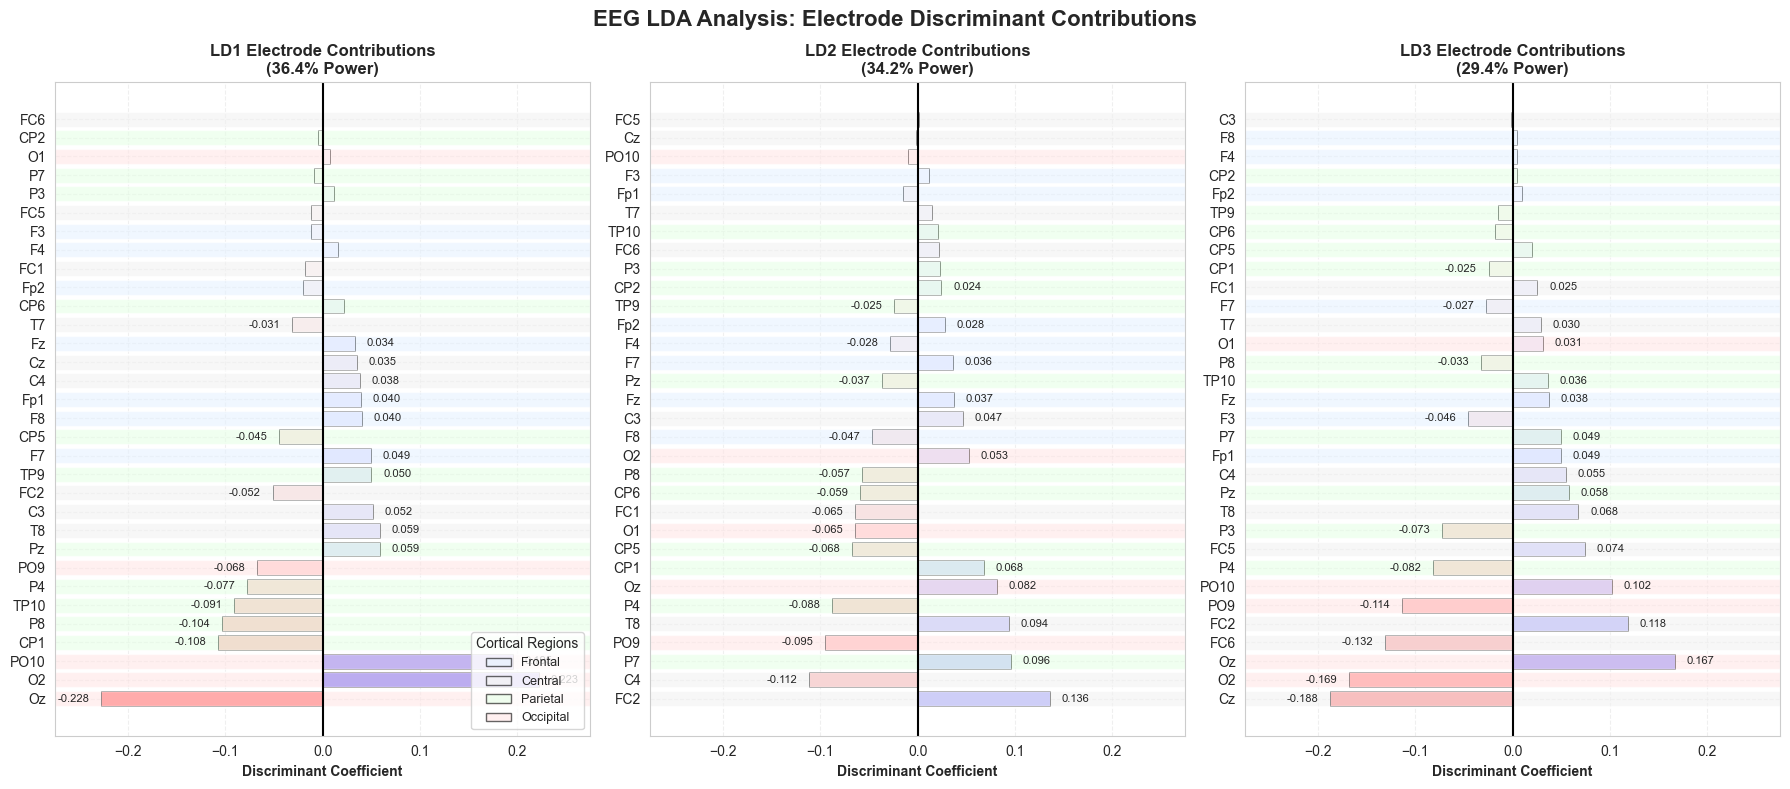


🧠 NEUROANATOMICAL INTERPRETATION OF DISCRIMINANT COMPONENTS

LD1 (36.4% discriminative power):
  Most discriminative region: Occipital
  Pattern type: biphasic

  Strongest discriminating electrodes:
     1. Oz    : -0.2278 (Occipital)
     2. O2    : +0.2229 (Occipital)
     3. PO10  : +0.1955 (Occipital)
     4. CP1   : -0.1078 (Parietal)
     5. P8    : -0.1036 (Parietal)
     6. TP10  : -0.0911 (Parietal)

LD2 (34.2% discriminative power):
  Most discriminative region: Occipital
  Pattern type: biphasic

  Strongest discriminating electrodes:
     1. FC2   : +0.1363 (Central)
     2. C4    : -0.1115 (Central)
     3. P7    : +0.0959 (Parietal)
     4. PO9   : -0.0949 (Occipital)
     5. T8    : +0.0942 (Central)
     6. P4    : -0.0877 (Parietal)

LD3 (29.4% discriminative power):
  Most discriminative region: Occipital
  Pattern type: biphasic

  Strongest discriminating electrodes:
     1. Cz    : -0.1877 (Central)
     2. O2    : -0.1687 (Occipital)
     3. Oz    : +0.1672 (Occ

In [53]:

electrode_coefficients, actual_electrodes = analyze_actual_electrodes_and_create_lda_maps(
        lda_results, feature_cols, eeg_df)


🎯 DETAILED FREQUENCY-ELECTRODE LDA ANALYSIS
✓ Found 58 frequencies

==================== LD1 ANALYSIS ====================
Discriminative Power: 36.4%

Top 10 Discriminating Electrode-Frequency combinations:
   1. PO10 @    3.125Hz | Coefficient: +5.8064 | Importance: 5.8064
   2. FC6  @ 2.47395833333333Hz | Coefficient: -5.3534 | Importance: 5.3534
   3. T8   @ 2.40885416666667Hz | Coefficient: -4.8938 | Importance: 4.8938
   4. T8   @    3.125Hz | Coefficient: +4.4038 | Importance: 4.4038
   5. FC1  @ 1.69270833333333Hz | Coefficient: +4.1888 | Importance: 4.1888
   6. O2   @ 2.86458333333333Hz | Coefficient: +3.9550 | Importance: 3.9550
   7. O2   @ 3.19010416666667Hz | Coefficient: +3.8834 | Importance: 3.8834
   8. FC1  @ 1.43229166666667Hz | Coefficient: +3.8197 | Importance: 3.8197
   9. O2   @ 0.5859375Hz | Coefficient: -3.7408 | Importance: 3.7408
  10. FC6  @ 0.325520833333333Hz | Coefficient: +3.7244 | Importance: 3.7244

==================== LD2 ANALYSIS ==================

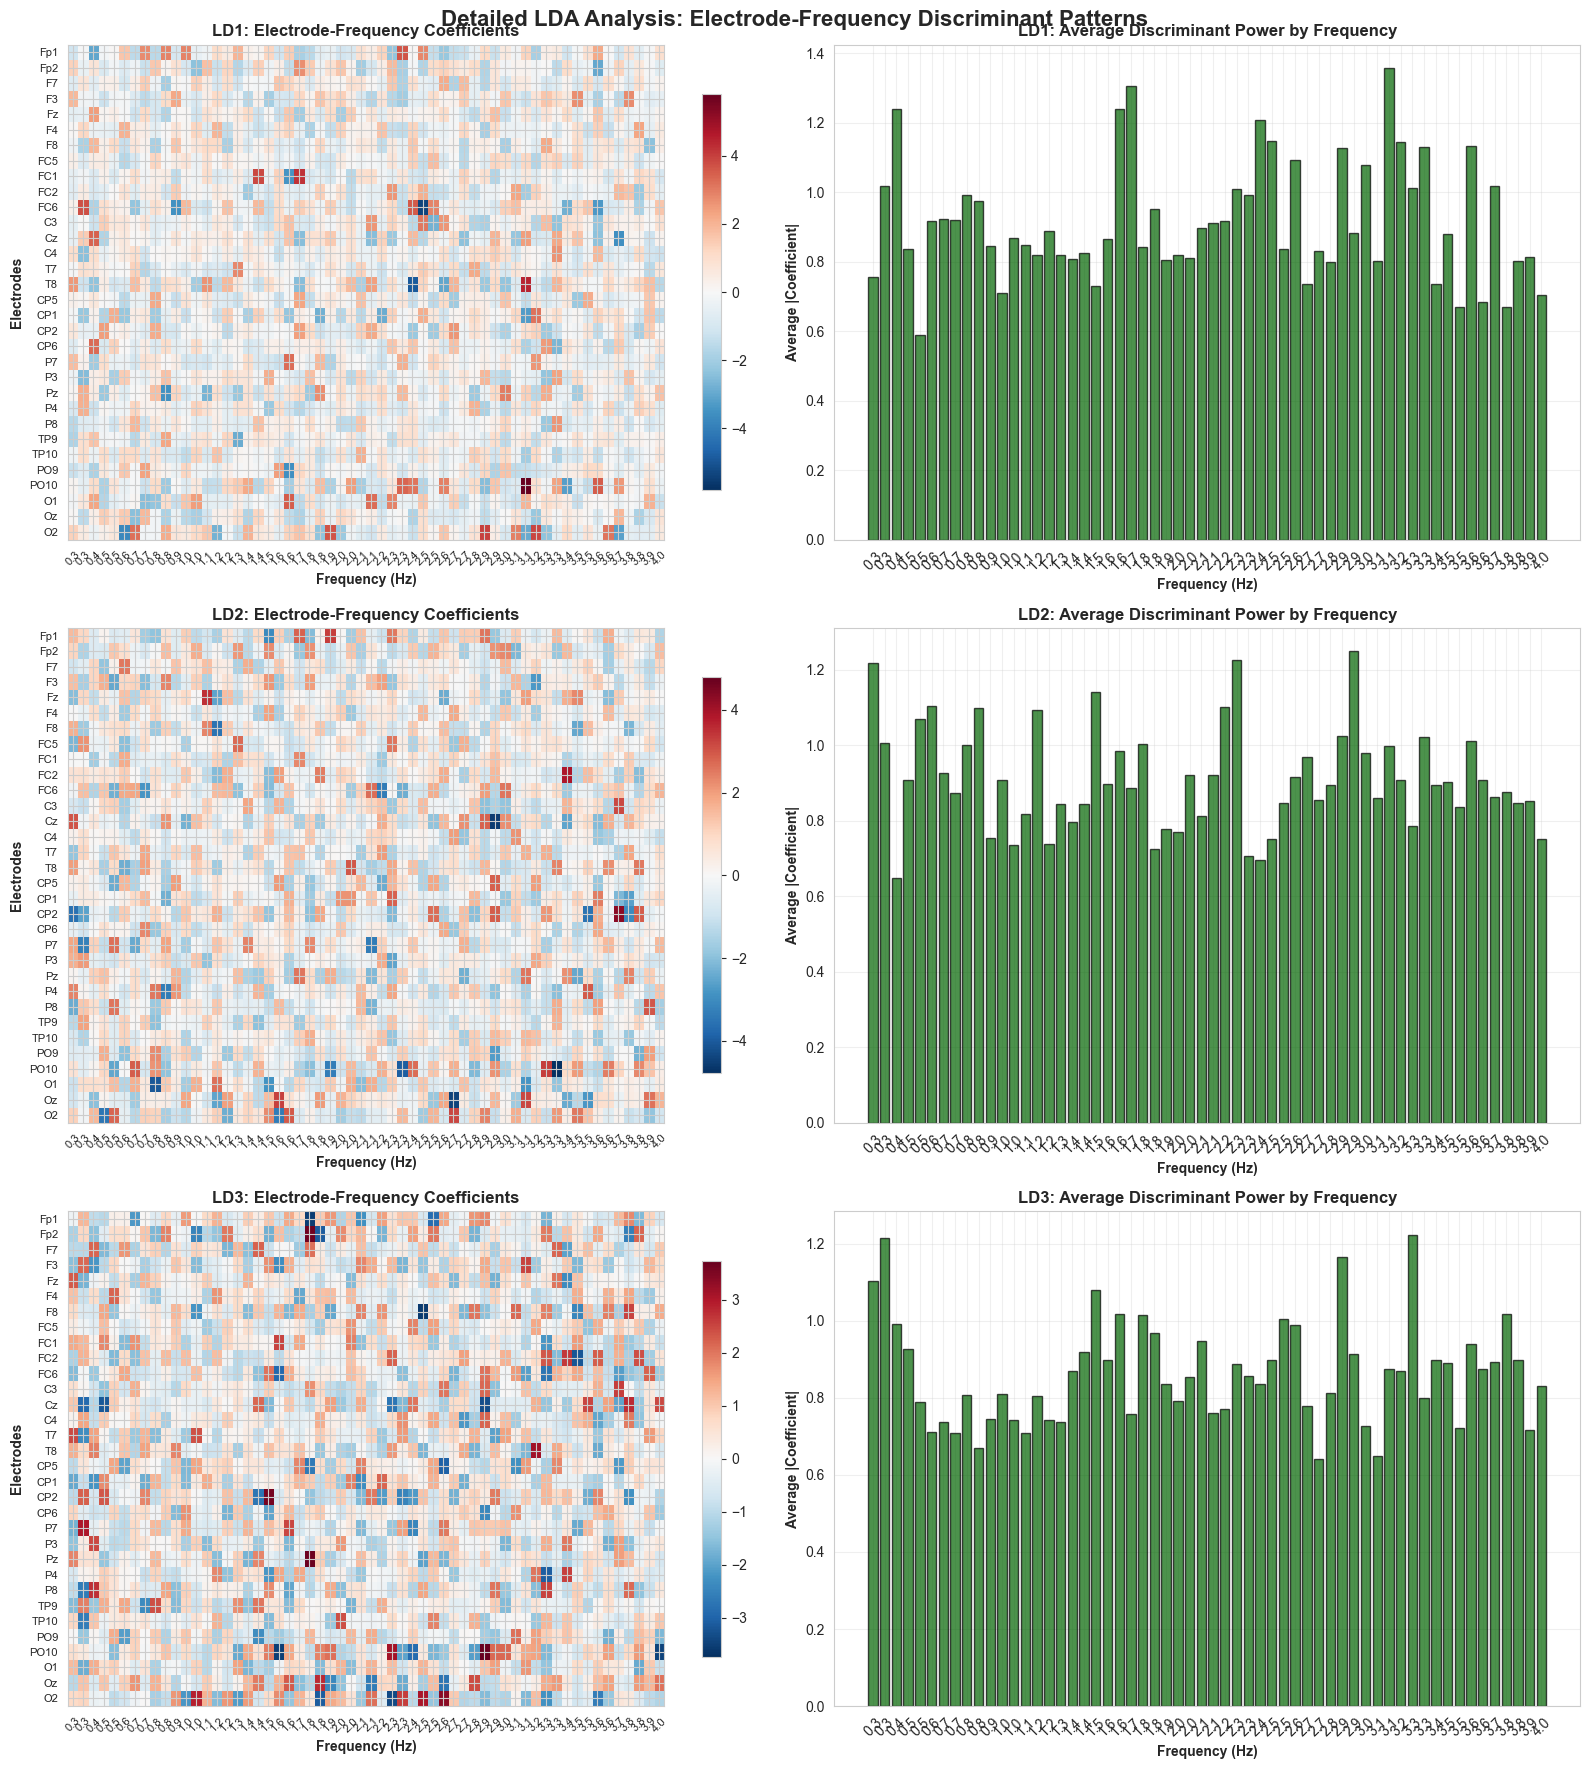

In [54]:
def analyze_frequency_electrode_lda_patterns(results, feature_cols):
    """Analyze electrode-frequency patterns for each discriminant component"""
    
    print(f"\n🎯 DETAILED FREQUENCY-ELECTRODE LDA ANALYSIS")
    print("=" * 55)
    
    scalings = results['model'].scalings_
    n_components = results['n_components']
    
    # Extract frequencies
    frequencies = set()
    for feature in feature_cols:
        freq_str = feature.split('_')[1].replace('Hz', '')
        try:
            freq = float(freq_str)
            frequencies.add(freq)
        except ValueError:
            continue
    
    frequencies = sorted(frequencies)
    print(f"✓ Found {len(frequencies)} frequencies")
    
    # Define brain regions
    brain_regions = {
        'Frontal': ['Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8'],
        'Fronto-Central': ['FC5', 'FC1', 'FC2', 'FC6'],
        'Central': ['C3', 'Cz', 'C4'],
        'Temporal': ['T7', 'T8'],
        'Central-Parietal': ['CP5', 'CP1', 'CP2', 'CP6'],
        'Parietal': ['P7', 'P3', 'Pz', 'P4', 'P8'],
        'Temporal-Parietal': ['TP9', 'TP10'],
        'Parieto-Occipital': ['PO9', 'PO10'],
        'Occipital': ['O1', 'Oz', 'O2']
    }
    
    # Create analysis plots
    fig, axes = plt.subplots(n_components, 2, figsize=(16, 6*n_components))
    if n_components == 1:
        axes = axes.reshape(1, -1)
        
    fig.suptitle('Detailed LDA Analysis: Electrode-Frequency Discriminant Patterns', 
                 fontsize=16, fontweight='bold')
    
    for ld_idx in range(n_components):
        coefficients = scalings[:, ld_idx]
        
        print(f"\n{'='*20} LD{ld_idx+1} ANALYSIS {'='*20}")
        print(f"Discriminative Power: {results['explained_variance_ratio'][ld_idx]:.1%}")
        
        # Organize data by electrode and frequency
        electrode_freq_data = {}
        for i, feature in enumerate(feature_cols):
            parts = feature.split('_')
            electrode = parts[0]
            freq_str = parts[1].replace('Hz', '')
            try:
                freq = float(freq_str)
            except ValueError:
                continue
            
            if electrode not in electrode_freq_data:
                electrode_freq_data[electrode] = {}
            electrode_freq_data[electrode][freq] = coefficients[i]
        
        # Create heatmap
        ax_heatmap = axes[ld_idx, 0]
        
        all_electrodes = []
        for region_electrodes in brain_regions.values():
            all_electrodes.extend(region_electrodes)
        
        electrodes = [e for e in all_electrodes if e in electrode_freq_data]
        
        heatmap_data = []
        for electrode in electrodes:
            row = []
            for freq in frequencies:
                if freq in electrode_freq_data.get(electrode, {}):
                    row.append(electrode_freq_data[electrode][freq])
                else:
                    row.append(0)
            heatmap_data.append(row)
        
        heatmap_data = np.array(heatmap_data)
        
        if heatmap_data.size > 0:
            vmax = max(abs(heatmap_data.min()), abs(heatmap_data.max()))
            im = ax_heatmap.imshow(heatmap_data, cmap='RdBu_r', aspect='auto', 
                                  vmin=-vmax, vmax=vmax)
            
            ax_heatmap.set_title(f'LD{ld_idx+1}: Electrode-Frequency Coefficients', 
                                fontweight='bold')
            ax_heatmap.set_xlabel('Frequency (Hz)', fontweight='bold')
            ax_heatmap.set_ylabel('Electrodes', fontweight='bold')
            ax_heatmap.set_xticks(range(len(frequencies)))
            freq_labels = [f"{freq:.1f}" if freq != int(freq) else str(int(freq)) for freq in frequencies]
            ax_heatmap.set_xticklabels(freq_labels, rotation=45, fontsize=8)
            ax_heatmap.set_yticks(range(len(electrodes)))
            ax_heatmap.set_yticklabels(electrodes, fontsize=8)
            
            plt.colorbar(im, ax=ax_heatmap, shrink=0.8)
        
        # Frequency analysis
        ax_freq = axes[ld_idx, 1]
        
        freq_coeffs = {}
        for freq in frequencies:
            freq_values = []
            for electrode in electrodes:
                if freq in electrode_freq_data.get(electrode, {}):
                    freq_values.append(abs(electrode_freq_data[electrode][freq]))
            if freq_values:
                freq_coeffs[freq] = np.mean(freq_values)
            else:
                freq_coeffs[freq] = 0
        
        freqs = list(freq_coeffs.keys())
        values = list(freq_coeffs.values())
        
        freq_labels_plot = [f"{freq:.1f}" if freq != int(freq) else str(int(freq)) for freq in freqs]
        
        bars = ax_freq.bar(range(len(freqs)), values, color='darkgreen', alpha=0.7, edgecolor='black')
        ax_freq.set_title(f'LD{ld_idx+1}: Average Discriminant Power by Frequency', fontweight='bold')
        ax_freq.set_xlabel('Frequency (Hz)', fontweight='bold')
        ax_freq.set_ylabel('Average |Coefficient|', fontweight='bold')
        ax_freq.set_xticks(range(len(freqs)))
        ax_freq.set_xticklabels(freq_labels_plot, rotation=45)
        ax_freq.grid(True, alpha=0.3)
        
        # Print detailed analysis
        print(f"\nTop 10 Discriminating Electrode-Frequency combinations:")
        feature_importance = [(feature_cols[i], abs(coefficients[i])) 
                            for i in range(len(feature_cols))]
        feature_importance.sort(key=lambda x: x[1], reverse=True)
        
        for i, (feature, importance) in enumerate(feature_importance[:10]):
            parts = feature.split('_')
            electrode = parts[0]
            freq_str = parts[1]
            coeff_val = coefficients[feature_cols.index(feature)]
            print(f"  {i+1:2d}. {electrode:4s} @ {freq_str:>10s} | "
                  f"Coefficient: {coeff_val:+.4f} | Importance: {importance:.4f}")
    
    plt.tight_layout()
    plt.show()
    
    return electrode_freq_data


lda_detailed_analysis = analyze_frequency_electrode_lda_patterns(lda_results, feature_cols)


Plotting LDA discriminant scores...


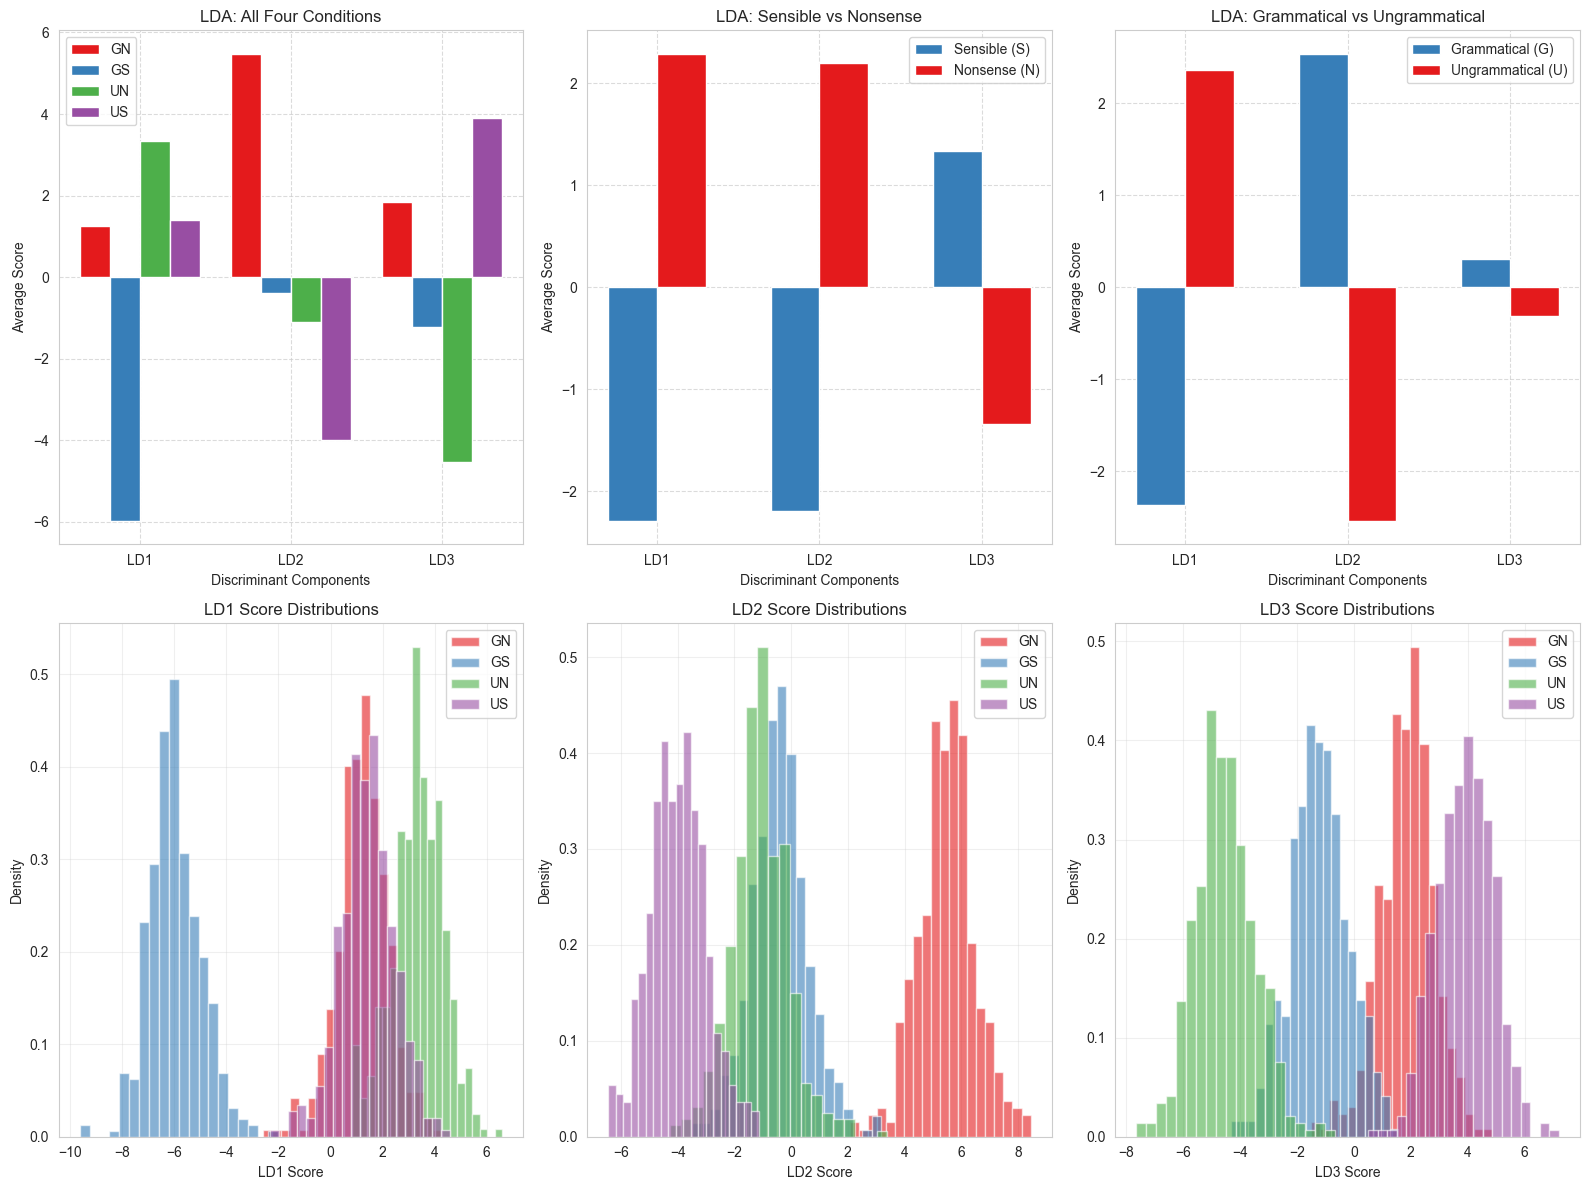


LDA Condition averages (discriminant scores):
GN: LD1=1.2458, LD2=5.4775, LD3=1.8494
GS: LD1=-5.9761, LD2=-0.3991, LD3=-1.2241
UN: LD1=3.3318, LD2=-1.0897, LD3=-4.5232
US: LD1=1.3985, LD2=-3.9887, LD3=3.8979

Sensible vs Nonsense differences:
LD1: -4.5776, LD2: -4.3878, LD3: 2.6738

Grammatical vs Ungrammatical differences:
LD1: -4.7303, LD2: 5.0784, LD3: 0.6253

LDA Classification Accuracy: 1.000 (100.0%)

💾 SAVING LDA DISCRIMINANT RESULTS
-----------------------------------
✓ Saved: Data/eeg_lda_discriminant_scores.csv
✓ Shape: (1680, 6)
✓ Columns: ['participant', 'trial', 'condition', 'LD1', 'LD2', 'LD3']

Sample data:
  participant  trial condition       LD1       LD2       LD3
0         S10      1        GN  1.892270  6.638002  1.612210
1         S10      2        GN  1.382145  5.302020  0.444845
2         S10      3        GN  0.582689  4.978092  0.917368
3         S10      4        GN  0.309739  5.793981  1.671010
4         S10      5        GN  1.432556  5.018073  2.575043

Co

In [55]:
def plot_condition_discriminant_scores(lda_results, y_conditions):
    """
    Plot LDA discriminant scores for different conditions.
    Shows how well LDA separates the conditions.
    """
    
    print("\nPlotting LDA discriminant scores...")
    
    X_lda = lda_results['data']
    n_components = lda_results['n_components']
    unique_conditions = np.unique(y_conditions)
    
    fig = plt.figure(figsize=(16, 12))
    
    # Define colors for conditions
    cond_colors = {
        'GN': '#e41a1c',  # Grammatical Nonsense - red
        'GS': '#377eb8',  # Grammatical Sensible - blue
        'UN': '#4daf4a',  # Ungrammatical Nonsense - green
        'US': '#984ea3'   # Ungrammatical Sensible - purple
    }
    
    # Calculate means for each condition and component
    condition_means = {}
    for cond in unique_conditions:
        mask = y_conditions == cond
        condition_means[cond] = np.mean(X_lda[mask], axis=0)
    
    # Plot 1: All conditions mean scores
    plt.subplot(2, 3, 1)
    width = 0.2
    x = np.arange(n_components)
    
    for i, cond in enumerate(unique_conditions):
        plt.bar(x + i*width, condition_means[cond], width, 
                label=cond, color=cond_colors[cond])
    
    plt.xlabel('Discriminant Components')
    plt.ylabel('Average Score')
    plt.title('LDA: All Four Conditions')
    plt.xticks(x + width*1.5, [f'LD{i+1}' for i in range(n_components)])
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Plot 2: Sensible vs Nonsense
    plt.subplot(2, 3, 2)
    s_mask = (y_conditions == 'GS') | (y_conditions == 'US')
    n_mask = (y_conditions == 'GN') | (y_conditions == 'UN')
    
    s_avg = np.mean(X_lda[s_mask], axis=0)
    n_avg = np.mean(X_lda[n_mask], axis=0)
    
    plt.bar(x - 0.15, s_avg, width=0.3, label='Sensible (S)', color='#377eb8')
    plt.bar(x + 0.15, n_avg, width=0.3, label='Nonsense (N)', color='#e41a1c')
    
    plt.xlabel('Discriminant Components')
    plt.ylabel('Average Score')
    plt.title('LDA: Sensible vs Nonsense')
    plt.xticks(x, [f'LD{i+1}' for i in range(n_components)])
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Plot 3: Grammatical vs Ungrammatical
    plt.subplot(2, 3, 3)
    g_mask = (y_conditions == 'GN') | (y_conditions == 'GS')
    u_mask = (y_conditions == 'UN') | (y_conditions == 'US')
    
    g_avg = np.mean(X_lda[g_mask], axis=0)
    u_avg = np.mean(X_lda[u_mask], axis=0)
    
    plt.bar(x - 0.15, g_avg, width=0.3, label='Grammatical (G)', color='#377eb8')
    plt.bar(x + 0.15, u_avg, width=0.3, label='Ungrammatical (U)', color='#e41a1c')
    
    plt.xlabel('Discriminant Components')
    plt.ylabel('Average Score')
    plt.title('LDA: Grammatical vs Ungrammatical')
    plt.xticks(x, [f'LD{i+1}' for i in range(n_components)])
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Plots 4-6: Individual component distributions
    for comp_idx in range(min(3, n_components)):
        plt.subplot(2, 3, 4 + comp_idx)
        
        for condition in unique_conditions:
            mask = y_conditions == condition
            scores = X_lda[mask, comp_idx]
            plt.hist(scores, alpha=0.6, label=f'{condition}', 
                   color=cond_colors[condition], bins=20, density=True)
        
        plt.xlabel(f'LD{comp_idx+1} Score')
        plt.ylabel('Density')
        plt.title(f'LD{comp_idx+1} Score Distributions')
        plt.legend()
        plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print("\nLDA Condition averages (discriminant scores):")
    for cond in unique_conditions:
        scores_str = ", ".join([f"LD{i+1}={condition_means[cond][i]:.4f}" 
                               for i in range(n_components)])
        print(f"{cond}: {scores_str}")
    
    # Print pairwise comparisons
    print("\nSensible vs Nonsense differences:")
    diff_str = ", ".join([f"LD{i+1}: {s_avg[i] - n_avg[i]:.4f}" 
                         for i in range(n_components)])
    print(diff_str)
    
    print("\nGrammatical vs Ungrammatical differences:")
    diff_str = ", ".join([f"LD{i+1}: {g_avg[i] - u_avg[i]:.4f}" 
                         for i in range(n_components)])
    print(diff_str)
    
    # Classification accuracy
    y_pred = lda_results['model'].predict(lda_results['scaler'].transform(X_original))
    accuracy = np.mean(y_pred == y_conditions)
    print(f"\nLDA Classification Accuracy: {accuracy:.3f} ({accuracy*100:.1f}%)")

def save_lda_results(lda_results, feature_matrix):
    """Save LDA discriminant results"""
    
    print(f"\n💾 SAVING LDA DISCRIMINANT RESULTS")
    print("-" * 35)
    
    # Create dataframe with discriminant components
    lda_df = pd.DataFrame({
        'participant': feature_matrix['participant'].values,
        'trial': feature_matrix['trial'].values,
        'condition': feature_matrix['condition'].values,
    })
    
    # Add discriminant components
    for i in range(lda_results['n_components']):
        lda_df[f'LD{i+1}'] = lda_results['data'][:, i]
    
    # Save to CSV
    filename = 'Data/eeg_lda_discriminant_scores.csv'
    lda_df.to_csv(filename, index=False)
    
    print(f"✓ Saved: {filename}")
    print(f"✓ Shape: {lda_df.shape}")
    print(f"✓ Columns: {list(lda_df.columns)}")
    
    # Show sample data
    print(f"\nSample data:")
    print(lda_df.head())
    
    # Show condition distribution
    print(f"\nCondition distribution:")
    print(lda_df['condition'].value_counts())
    
    return filename, lda_df

# Call the function and save results
if 'lda_results' in locals() and 'y_conditions' in locals():
    plot_condition_discriminant_scores(lda_results, y_conditions)

# Save LDA results
if 'lda_results' in locals():
    lda_output_file, final_lda_df = save_lda_results(lda_results, feature_matrix)

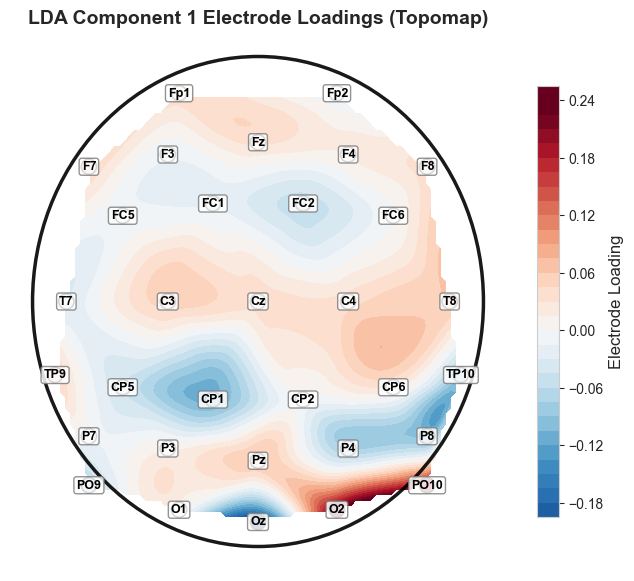

In [56]:
def plot_electrode_loadings_topomap(lda_results, feature_cols, component=0):
    """
    Plot a topographic map of electrode loadings for a given LDA component.
    """
    import matplotlib.pyplot as plt
    import numpy as np

    # 10-20 electrode positions (same as your previous code)
    electrode_positions = {
        'Fp1': (-0.35, 0.85), 'Fp2': (0.35, 0.85),
        'F7': (-0.75, 0.55), 'F3': (-0.4, 0.6), 'Fz': (0.0, 0.65), 'F4': (0.4, 0.6), 'F8': (0.75, 0.55),
        'FC5': (-0.6, 0.35), 'FC1': (-0.2, 0.4), 'FC2': (0.2, 0.4), 'FC6': (0.6, 0.35),
        'T7': (-0.85, 0.0), 'C3': (-0.4, 0.0), 'Cz': (0.0, 0.0), 'C4': (0.4, 0.0), 'T8': (0.85, 0.0),
        'CP5': (-0.6, -0.35), 'CP1': (-0.2, -0.4), 'CP2': (0.2, -0.4), 'CP6': (0.6, -0.35),
        'P7': (-0.75, -0.55), 'P3': (-0.4, -0.6), 'Pz': (0.0, -0.65), 'P4': (0.4, -0.6), 'P8': (0.75, -0.55),
        'PO9': (-0.75, -0.75), 'PO10': (0.75, -0.75),
        'TP9': (-0.9, -0.3), 'TP10': (0.9, -0.3),
        'O1': (-0.35, -0.85), 'Oz': (0.0, -0.9), 'O2': (0.35, -0.85)
    }

    # Get loadings for the selected component
    scalings = lda_results['model'].scalings_[:, component]
    # Average across frequencies for each electrode
    electrode_loadings = {}
    for i, feature in enumerate(feature_cols):
        electrode = feature.split('_')[0]
        if electrode not in electrode_loadings:
            electrode_loadings[electrode] = []
        electrode_loadings[electrode].append(scalings[i])
    for electrode in electrode_loadings:
        electrode_loadings[electrode] = np.mean(electrode_loadings[electrode])

    # Prepare data for plotting
    actual_electrodes = [e for e in electrode_loadings if e in electrode_positions]
    x = np.array([electrode_positions[e][0] for e in actual_electrodes])
    y = np.array([electrode_positions[e][1] for e in actual_electrodes])
    z = np.array([electrode_loadings[e] for e in actual_electrodes])

    # Interpolate for smooth topomap
    from scipy.interpolate import griddata
    xi = np.linspace(-1.1, 1.1, 100)
    yi = np.linspace(-1.1, 1.1, 100)
    Xi, Yi = np.meshgrid(xi, yi)
    Zi = griddata((x, y), z, (Xi, Yi), method='cubic', fill_value=np.nan)

    # Mask outside head
    mask = (Xi**2/0.9 + Yi**2) <= 1.15
    Zi[~mask] = np.nan

    plt.figure(figsize=(8, 7))
    im = plt.contourf(Xi, Yi, Zi, levels=30, cmap='RdBu_r', vmin=-np.nanmax(abs(z)), vmax=np.nanmax(abs(z)))
    plt.scatter(x, y, c=z, cmap='RdBu_r', s=120, edgecolors='k', linewidths=1.2, vmin=-np.nanmax(abs(z)), vmax=np.nanmax(abs(z)))
    for i, label in enumerate(actual_electrodes):
        plt.text(x[i], y[i], label, ha='center', va='center', fontsize=9, fontweight='bold', color='k',
                 bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.85, edgecolor='gray'))
    # Draw head outline
    head = plt.Circle((0, 0), 1, fill=False, linewidth=2.5, color='k', alpha=0.9)
    plt.gca().add_patch(head)
    plt.axis('off')
    plt.title(f'LDA Component {component+1} Electrode Loadings (Topomap)', fontsize=14, fontweight='bold')
    cbar = plt.colorbar(im, shrink=0.8)
    cbar.set_label('Electrode Loading', fontsize=12)
    plt.show()

# Example usage: plot for LD1 (component=0)
plot_electrode_loadings_topomap(lda_results, feature_cols, component=0)

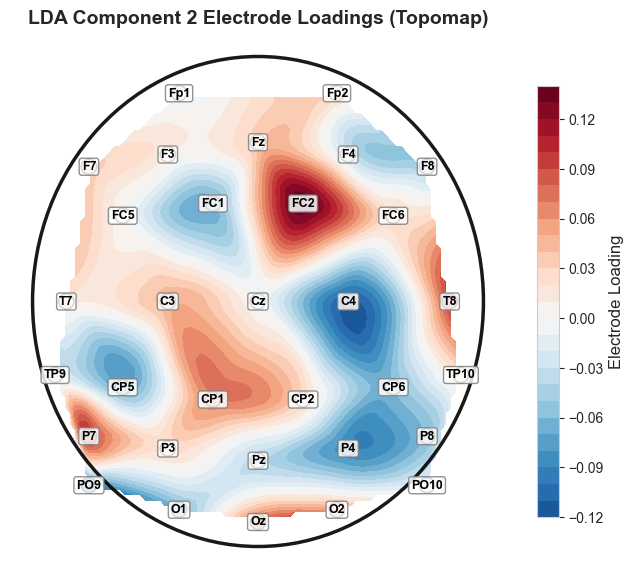

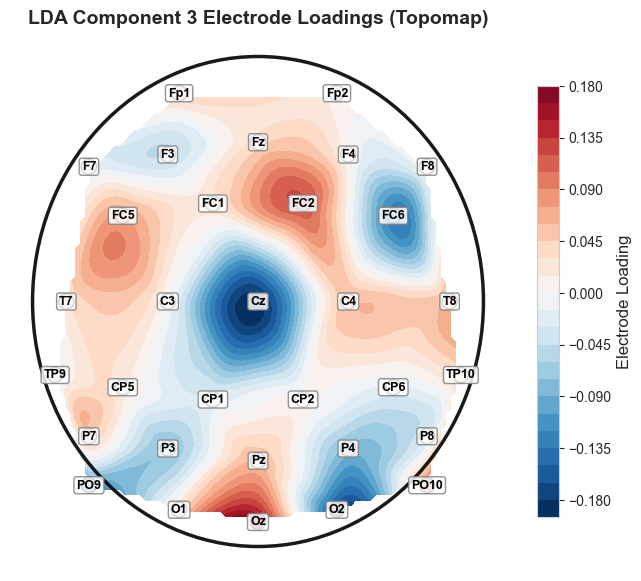

In [57]:
plot_electrode_loadings_topomap(lda_results, feature_cols, component=1)  # LD2

plot_electrode_loadings_topomap(lda_results, feature_cols, component=2)  # LD3 (if available)

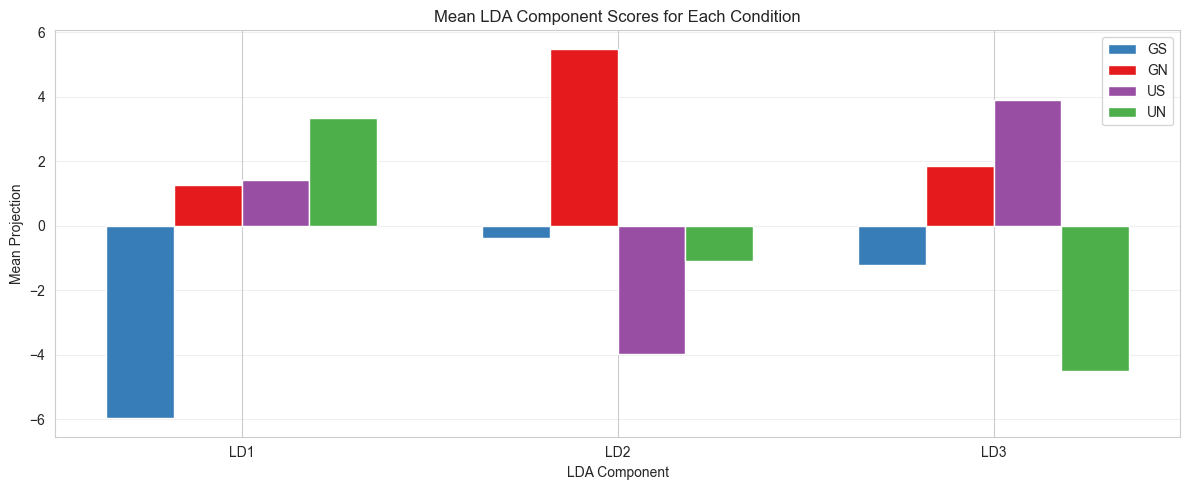

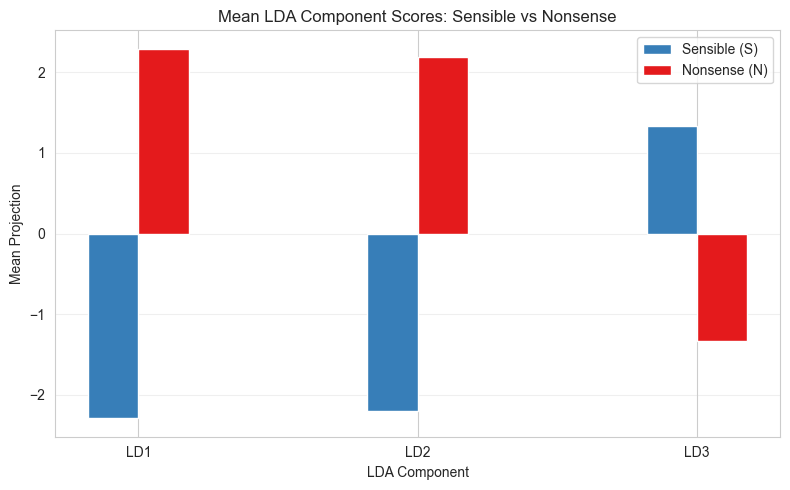

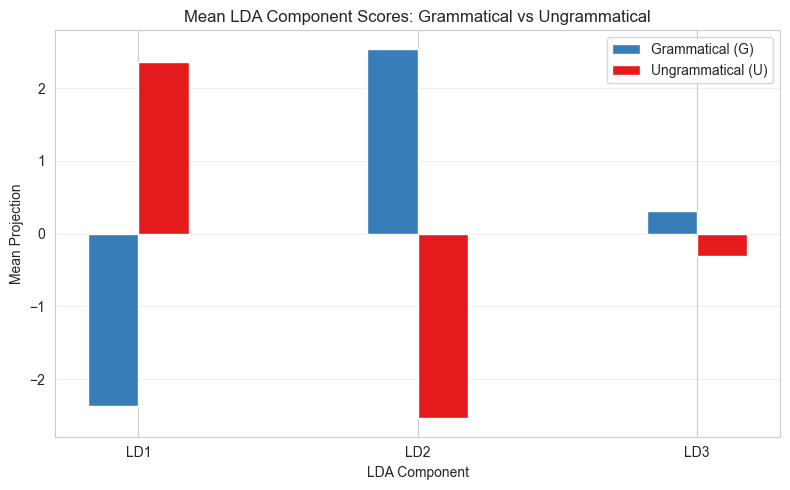

In [58]:
def plot_lda_condition_projections(lda_results, y_conditions):
    """
    Plot the projection (mean LDA component scores) for each condition and for S vs N, G vs U.
    """
    import numpy as np
    import matplotlib.pyplot as plt

    X_lda = lda_results['data']
    n_components = lda_results['n_components']
    unique_conditions = np.unique(y_conditions)

    # Map for colors
    cond_colors = {
        'GS': '#377eb8',  # Grammatical Sensible - blue
        'GN': '#e41a1c',  # Grammatical Nonsense - red
        'US': '#984ea3',  # Ungrammatical Sensible - purple
        'UN': '#4daf4a',  # Ungrammatical Nonsense - green
        'S': '#377eb8',
        'N': '#e41a1c',
        'G': '#377eb8',
        'U': '#e41a1c'
    }

    # --- 1. Four conditions ---
    plt.figure(figsize=(12, 5))
    width = 0.18
    x = np.arange(n_components)
    for i, cond in enumerate(['GS', 'GN', 'US', 'UN']):
        mask = (y_conditions == cond)
        mean_proj = np.mean(X_lda[mask], axis=0)
        plt.bar(x + i*width, mean_proj, width, label=cond, color=cond_colors[cond])
    plt.xticks(x + width*1.5, [f'LD{i+1}' for i in range(n_components)])
    plt.xlabel('LDA Component')
    plt.ylabel('Mean Projection')
    plt.title('Mean LDA Component Scores for Each Condition')
    plt.legend()
    plt.grid(True, axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

    # --- 2. S vs N ---
    plt.figure(figsize=(8, 5))
    S_mask = (y_conditions == 'GS') | (y_conditions == 'US')
    N_mask = (y_conditions == 'GN') | (y_conditions == 'UN')
    S_mean = np.mean(X_lda[S_mask], axis=0)
    N_mean = np.mean(X_lda[N_mask], axis=0)
    plt.bar(x - width/2, S_mean, width, label='Sensible (S)', color=cond_colors['S'])
    plt.bar(x + width/2, N_mean, width, label='Nonsense (N)', color=cond_colors['N'])
    plt.xticks(x, [f'LD{i+1}' for i in range(n_components)])
    plt.xlabel('LDA Component')
    plt.ylabel('Mean Projection')
    plt.title('Mean LDA Component Scores: Sensible vs Nonsense')
    plt.legend()
    plt.grid(True, axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

    # --- 3. G vs U ---
    plt.figure(figsize=(8, 5))
    G_mask = (y_conditions == 'GS') | (y_conditions == 'GN')
    U_mask = (y_conditions == 'US') | (y_conditions == 'UN')
    G_mean = np.mean(X_lda[G_mask], axis=0)
    U_mean = np.mean(X_lda[U_mask], axis=0)
    plt.bar(x - width/2, G_mean, width, label='Grammatical (G)', color=cond_colors['G'])
    plt.bar(x + width/2, U_mean, width, label='Ungrammatical (U)', color=cond_colors['U'])
    plt.xticks(x, [f'LD{i+1}' for i in range(n_components)])
    plt.xlabel('LDA Component')
    plt.ylabel('Mean Projection')
    plt.title('Mean LDA Component Scores: Grammatical vs Ungrammatical')
    plt.legend()
    plt.grid(True, axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

# Usage:
plot_lda_condition_projections(lda_results, y_conditions)

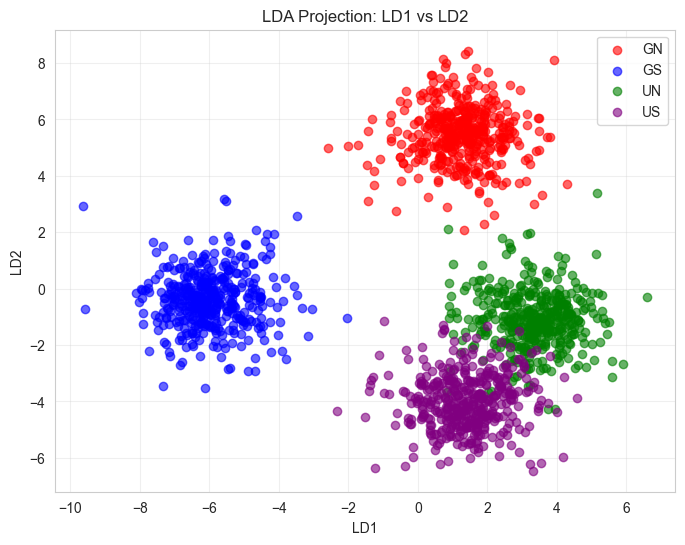

In [59]:
import matplotlib.pyplot as plt
import numpy as np

def plot_lda_scatter(lda_results, y_conditions):
    X_lda = lda_results['data']
    n_components = lda_results['n_components']
    colors = {'GS': 'b', 'GN': 'r', 'US': 'purple', 'UN': 'g'}
    if n_components >= 2:
        plt.figure(figsize=(8,6))
        for cond in np.unique(y_conditions):
            mask = y_conditions == cond
            plt.scatter(X_lda[mask,0], X_lda[mask,1], label=cond, alpha=0.6, c=colors[cond])
        plt.xlabel('LD1')
        plt.ylabel('LD2')
        plt.title('LDA Projection: LD1 vs LD2')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()

plot_lda_scatter(lda_results, y_conditions)

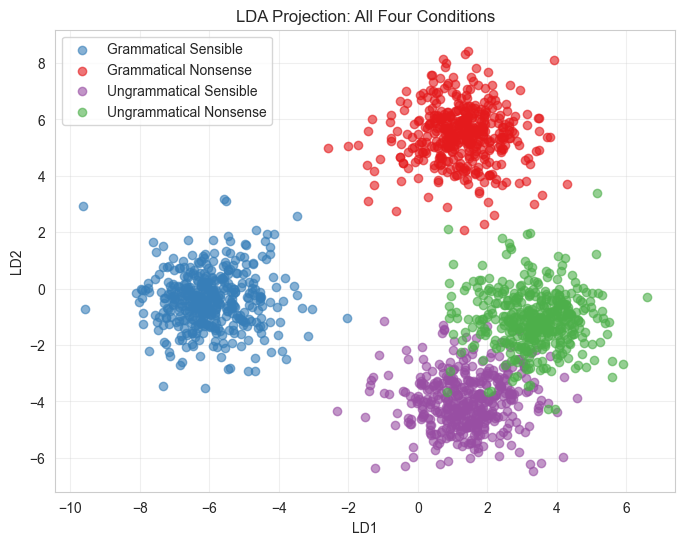

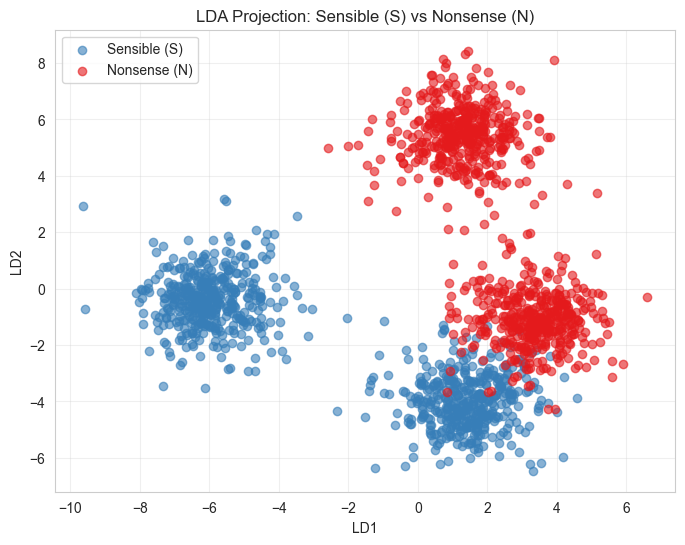

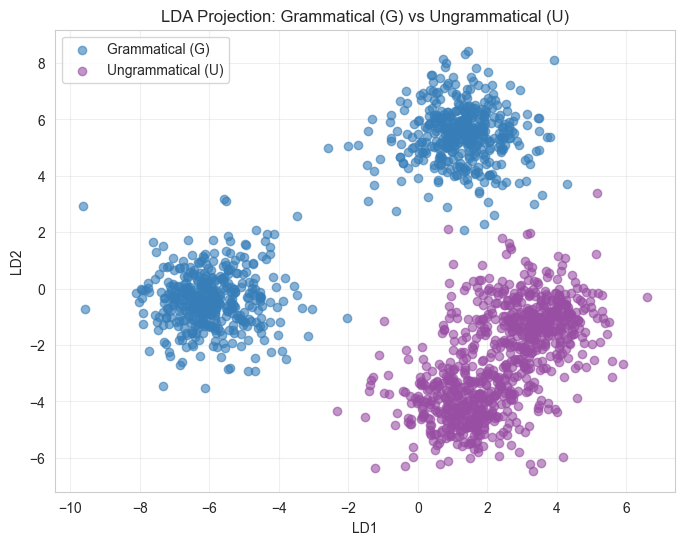

In [60]:
import matplotlib.pyplot as plt
import numpy as np

def plot_lda_scatter_all(lda_results, y_conditions):
    """
    Scatter plots of LDA projections for:
    - Each of the four conditions (GS, GN, US, UN)
    - Sensible (S) vs Nonsense (N)
    - Grammatical (G) vs Ungrammatical (U)
    """
    X_lda = lda_results['data']
    n_components = lda_results['n_components']
    colors = {'GS': '#377eb8', 'GN': '#e41a1c', 'US': '#984ea3', 'UN': '#4daf4a'}
    labels = {'GS': 'Grammatical Sensible', 'GN': 'Grammatical Nonsense',
              'US': 'Ungrammatical Sensible', 'UN': 'Ungrammatical Nonsense'}

    # 1. Four conditions
    if n_components >= 2:
        plt.figure(figsize=(8,6))
        for cond in ['GS', 'GN', 'US', 'UN']:
            mask = y_conditions == cond
            plt.scatter(X_lda[mask,0], X_lda[mask,1], label=labels[cond], alpha=0.6, c=colors[cond])
        plt.xlabel('LD1')
        plt.ylabel('LD2')
        plt.title('LDA Projection: All Four Conditions')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()

    # 2. Sensible (S) vs Nonsense (N)
    if n_components >= 2:
        plt.figure(figsize=(8,6))
        S_mask = (y_conditions == 'GS') | (y_conditions == 'US')
        N_mask = (y_conditions == 'GN') | (y_conditions == 'UN')
        plt.scatter(X_lda[S_mask,0], X_lda[S_mask,1], label='Sensible (S)', alpha=0.6, c='#377eb8')
        plt.scatter(X_lda[N_mask,0], X_lda[N_mask,1], label='Nonsense (N)', alpha=0.6, c='#e41a1c')
        plt.xlabel('LD1')
        plt.ylabel('LD2')
        plt.title('LDA Projection: Sensible (S) vs Nonsense (N)')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()

    # 3. Grammatical (G) vs Ungrammatical (U)
    if n_components >= 2:
        plt.figure(figsize=(8,6))
        G_mask = (y_conditions == 'GS') | (y_conditions == 'GN')
        U_mask = (y_conditions == 'US') | (y_conditions == 'UN')
        plt.scatter(X_lda[G_mask,0], X_lda[G_mask,1], label='Grammatical (G)', alpha=0.6, c='#377eb8')
        plt.scatter(X_lda[U_mask,0], X_lda[U_mask,1], label='Ungrammatical (U)', alpha=0.6, c='#984ea3')
        plt.xlabel('LD1')
        plt.ylabel('LD2')
        plt.title('LDA Projection: Grammatical (G) vs Ungrammatical (U)')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()

# Usage:
plot_lda_scatter_all(lda_results, y_conditions)

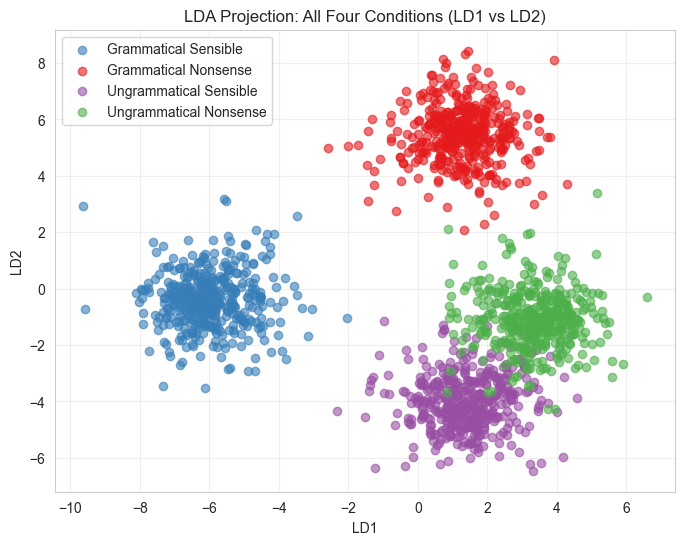

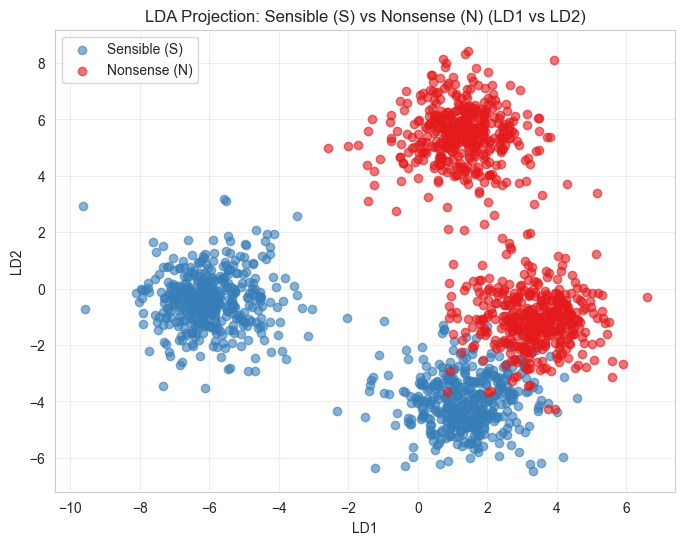

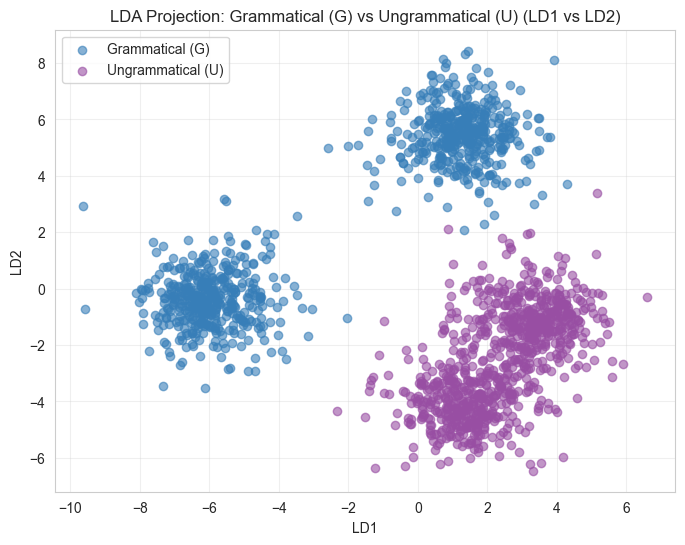

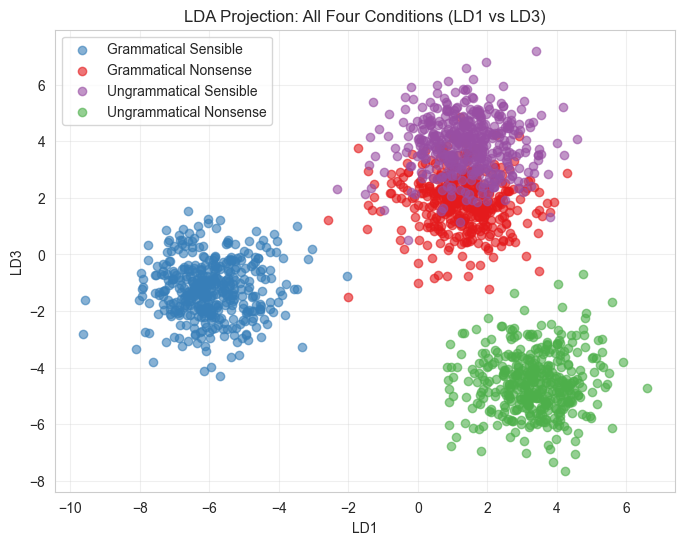

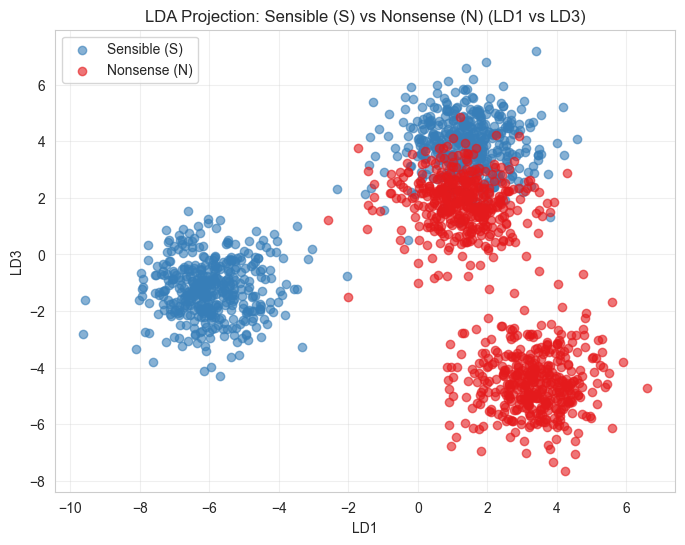

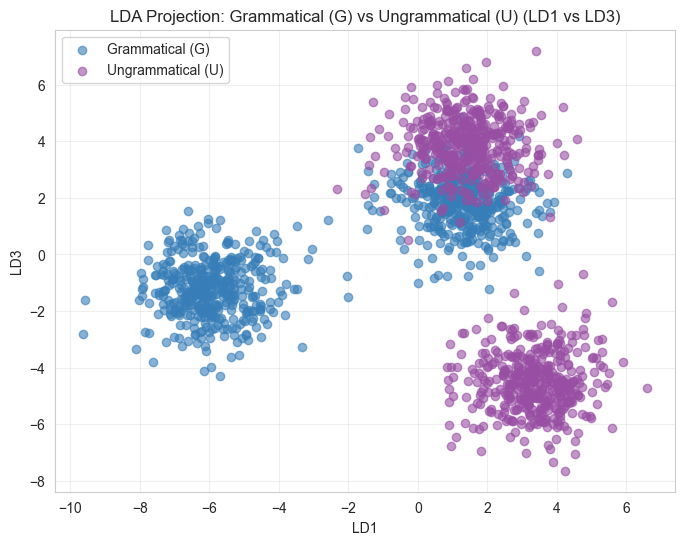

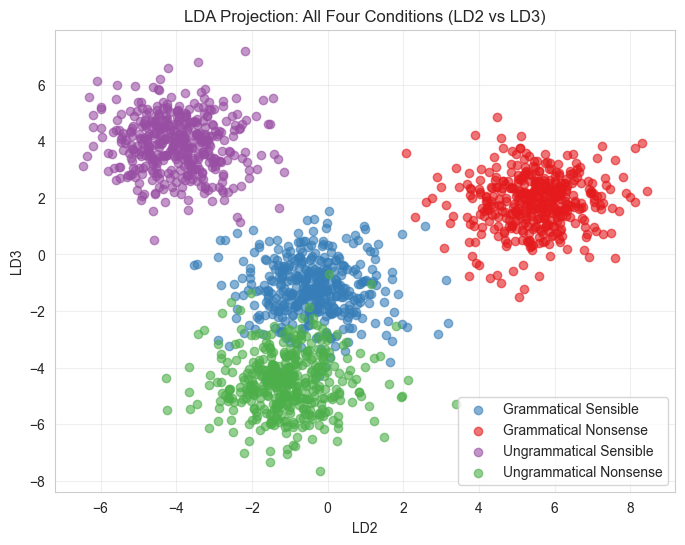

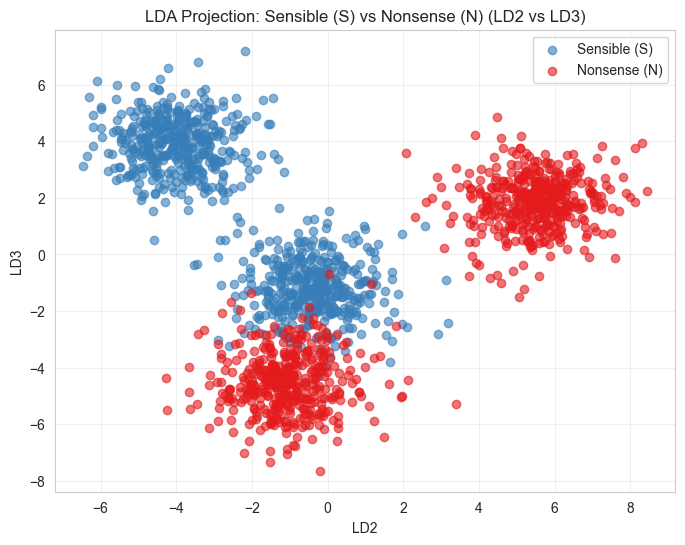

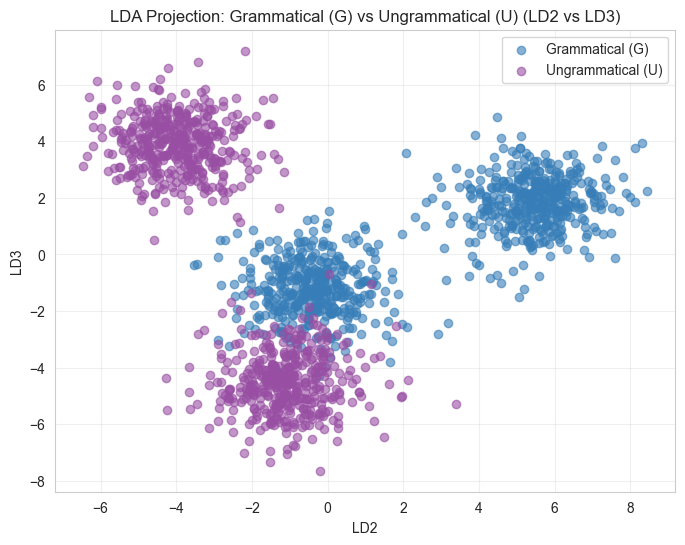

In [61]:
import matplotlib.pyplot as plt
import numpy as np

def plot_lda_scatter_all_components(lda_results, y_conditions):
    """
    Scatter plots of LDA projections for all pairs of the first 3 components:
    - Each of the four conditions (GS, GN, US, UN)
    - Sensible (S) vs Nonsense (N)
    - Grammatical (G) vs Ungrammatical (U)
    """
    X_lda = lda_results['data']
    n_components = lda_results['n_components']
    colors = {'GS': '#377eb8', 'GN': '#e41a1c', 'US': '#984ea3', 'UN': '#4daf4a'}
    labels = {'GS': 'Grammatical Sensible', 'GN': 'Grammatical Nonsense',
              'US': 'Ungrammatical Sensible', 'UN': 'Ungrammatical Nonsense'}

    # Only plot if at least 2 components
    max_comp = min(3, n_components)
    pairs = [(i, j) for i in range(max_comp) for j in range(i+1, max_comp)]

    for (i, j) in pairs:
        # 1. Four conditions
        plt.figure(figsize=(8,6))
        for cond in ['GS', 'GN', 'US', 'UN']:
            mask = y_conditions == cond
            plt.scatter(X_lda[mask, i], X_lda[mask, j], label=labels[cond], alpha=0.6, c=colors[cond])
        plt.xlabel(f'LD{i+1}')
        plt.ylabel(f'LD{j+1}')
        plt.title(f'LDA Projection: All Four Conditions (LD{i+1} vs LD{j+1})')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()

        # 2. Sensible (S) vs Nonsense (N)
        plt.figure(figsize=(8,6))
        S_mask = (y_conditions == 'GS') | (y_conditions == 'US')
        N_mask = (y_conditions == 'GN') | (y_conditions == 'UN')
        plt.scatter(X_lda[S_mask, i], X_lda[S_mask, j], label='Sensible (S)', alpha=0.6, c='#377eb8')
        plt.scatter(X_lda[N_mask, i], X_lda[N_mask, j], label='Nonsense (N)', alpha=0.6, c='#e41a1c')
        plt.xlabel(f'LD{i+1}')
        plt.ylabel(f'LD{j+1}')
        plt.title(f'LDA Projection: Sensible (S) vs Nonsense (N) (LD{i+1} vs LD{j+1})')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()

        # 3. Grammatical (G) vs Ungrammatical (U)
        plt.figure(figsize=(8,6))
        G_mask = (y_conditions == 'GS') | (y_conditions == 'GN')
        U_mask = (y_conditions == 'US') | (y_conditions == 'UN')
        plt.scatter(X_lda[G_mask, i], X_lda[G_mask, j], label='Grammatical (G)', alpha=0.6, c='#377eb8')
        plt.scatter(X_lda[U_mask, i], X_lda[U_mask, j], label='Ungrammatical (U)', alpha=0.6, c='#984ea3')
        plt.xlabel(f'LD{i+1}')
        plt.ylabel(f'LD{j+1}')
        plt.title(f'LDA Projection: Grammatical (G) vs Ungrammatical (U) (LD{i+1} vs LD{j+1})')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()

# Usage:
plot_lda_scatter_all_components(lda_results, y_conditions)

In [62]:
def plot_lda_scatter_all_components(lda_results, y_conditions):
    """
    Scatter plots of LDA projections for all pairs of the first 3 components:
    - Each of the four conditions (GS, GN, US, UN)
    - Sensible (S) vs Nonsense (N)
    - Grammatical (G) vs Ungrammatical (U)
    """
    X_lda = lda_results['data']
    n_components = lda_results['n_components']
    colors = {'GS': '#377eb8', 'GN': '#e41a1c', 'US': '#984ea3', 'UN': '#4daf4a'}
    labels = {'GS': 'Grammatical Sensible', 'GN': 'Grammatical Nonsense',
              'US': 'Ungrammatical Sensible', 'UN': 'Ungrammatical Nonsense'}

    # Only plot if at least 2 components
    max_comp = min(3, n_components)
    pairs = [(i, j) for i in range(max_comp) for j in range(i+1, max_comp)]

    for (i, j) in pairs:
        # 1. Four conditions
        plt.figure(figsize=(8,6))
        for cond in ['GS', 'GN', 'US', 'UN']:
            mask = y_conditions == cond
            plt.scatter(X_lda[mask, i], X_lda[mask, j], label=labels[cond], alpha=0.6, c=colors[cond])
        plt.xlabel(f'LD{i+1}')
        plt.ylabel(f'LD{j+1}')
        plt.title(f'LDA Projection: All Four Conditions (LD{i+1} vs LD{j+1})')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()

        # 2. Sensible (S) vs Nonsense (N)
        plt.figure(figsize=(8,6))
        S_mask = (y_conditions == 'GS') | (y_conditions == 'US')
        N_mask = (y_conditions == 'GN') | (y_conditions == 'UN')
        plt.scatter(X_lda[S_mask, i], X_lda[S_mask, j], label='Sensible (S)', alpha=0.6, c='#377eb8')
        plt.scatter(X_lda[N_mask, i], X_lda[N_mask, j], label='Nonsense (N)', alpha=0.6, c='#e41a1c')
        plt.xlabel(f'LD{i+1}')
        plt.ylabel(f'LD{j+1}')
        plt.title(f'LDA Projection: Sensible (S) vs Nonsense (N) (LD{i+1} vs LD{j+1})')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()

        # 3. Grammatical (G) vs Ungrammatical (U)
        plt.figure(figsize=(8,6))
        G_mask = (y_conditions == 'GS') | (y_conditions == 'GN')
        U_mask = (y_conditions == 'US') | (y_conditions == 'UN')
        plt.scatter(X_lda[G_mask, i], X_lda[G_mask, j], label='Grammatical (G)', alpha=0.6, c='#377eb8')
        plt.scatter(X_lda[U_mask, i], X_lda[U_mask, j], label='Ungrammatical (U)', alpha=0.6, c='#984ea3')
        plt.xlabel(f'LD{i+1}')
        plt.ylabel(f'LD{j+1}')
        plt.title(f'LDA Projection: Grammatical (G) vs Ungrammatical (U) (LD{i+1} vs LD{j+1})')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()

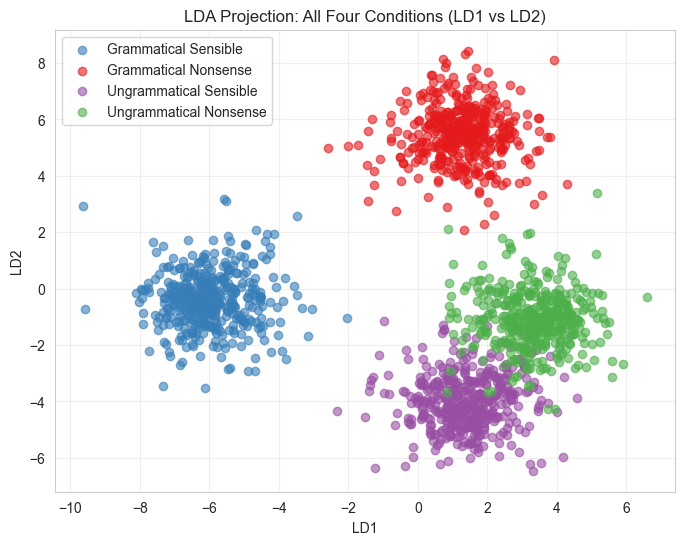

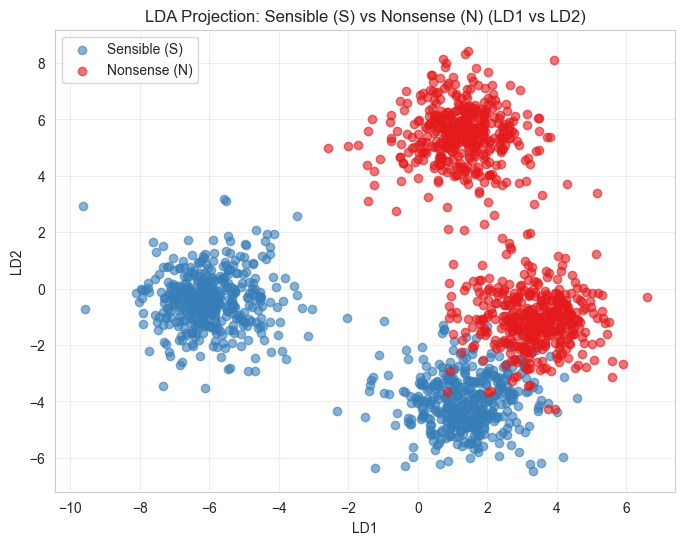

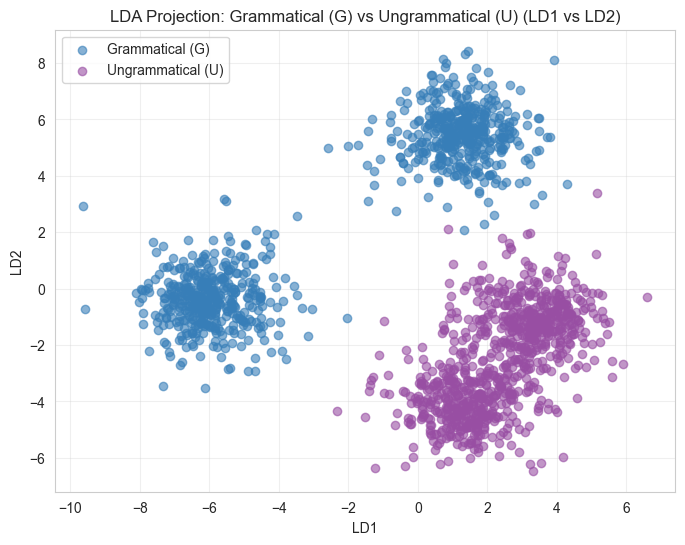

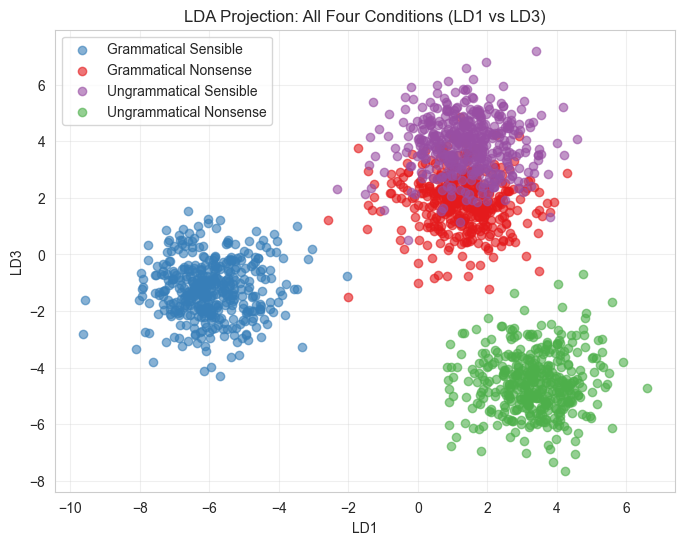

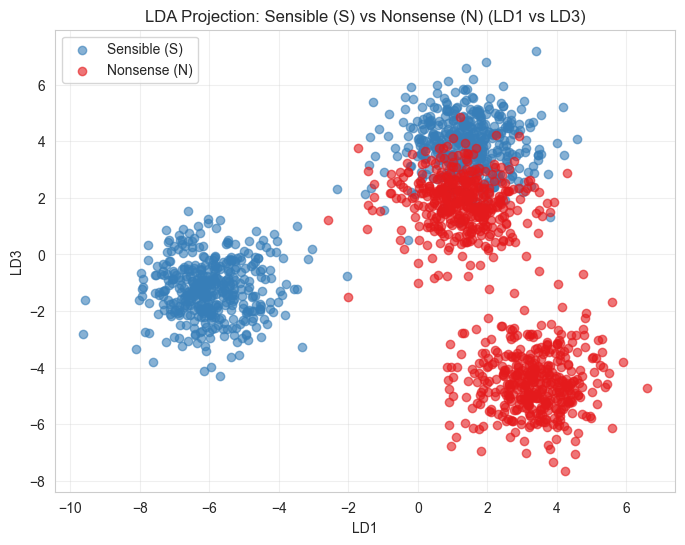

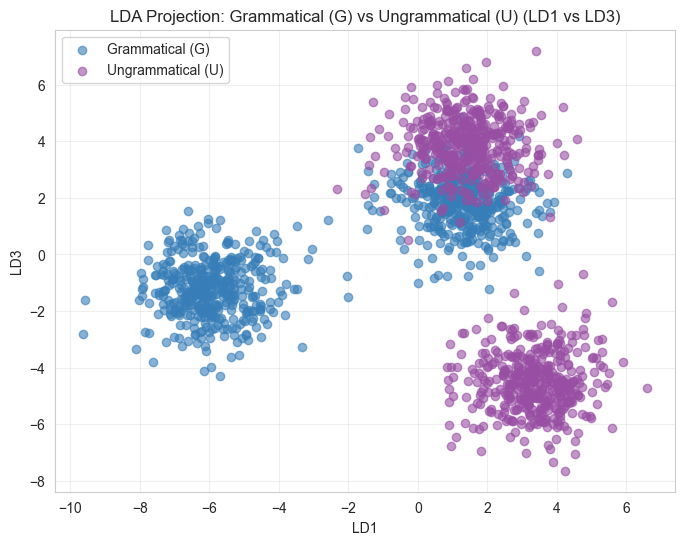

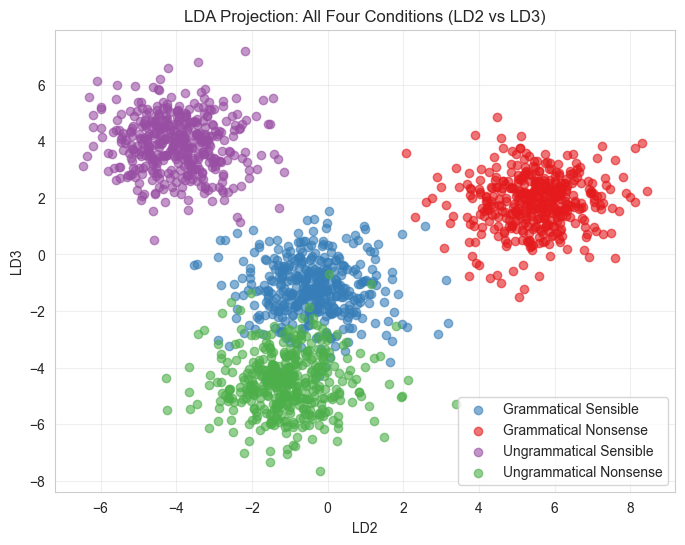

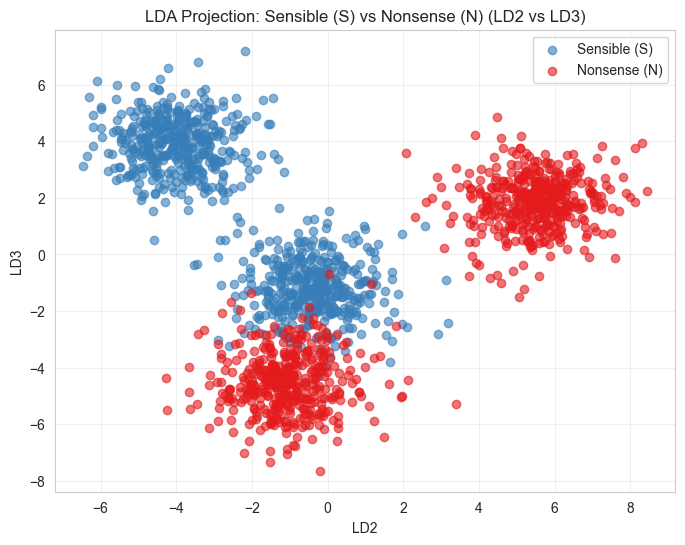

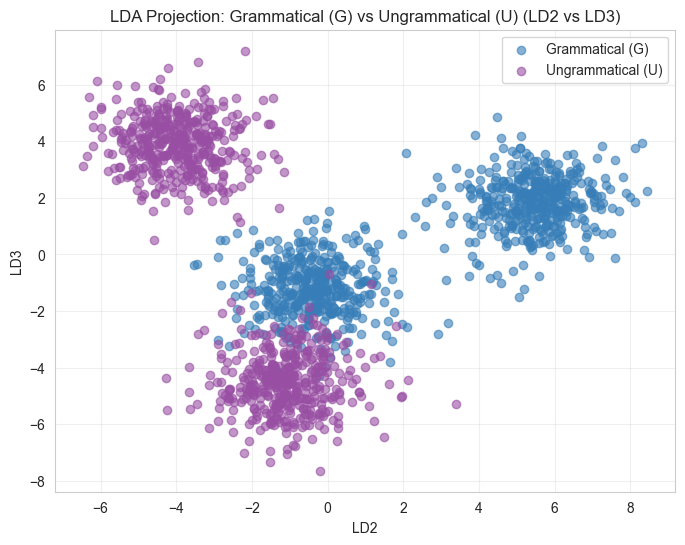

In [63]:
plot_lda_scatter_all_components(lda_results, y_conditions)

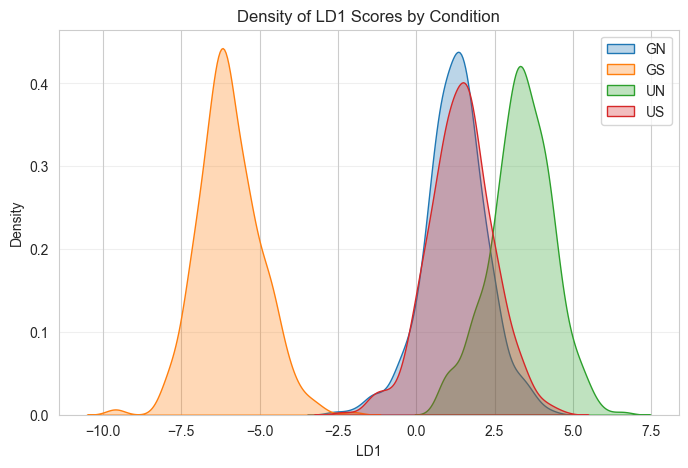

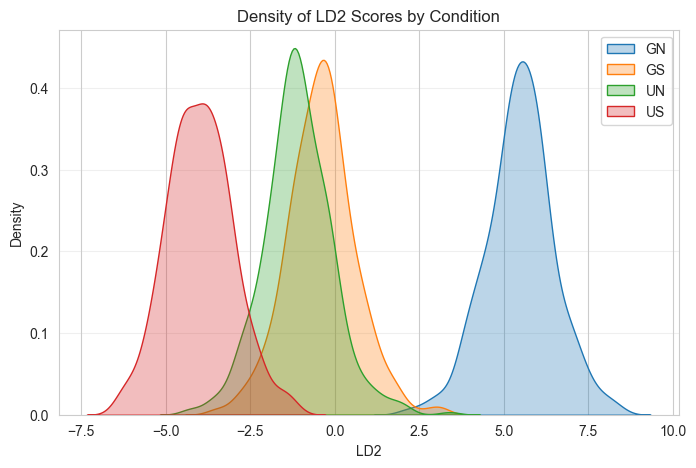

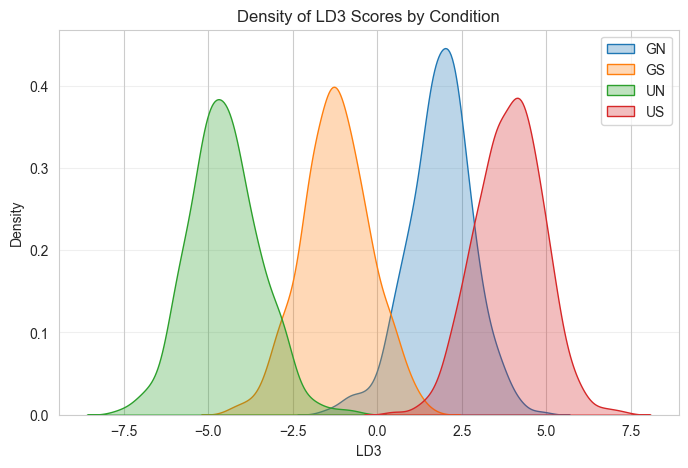

In [64]:
import seaborn as sns

def plot_lda_density(lda_results, y_conditions):
    X_lda = lda_results['data']
    n_components = lda_results['n_components']
    df = pd.DataFrame(X_lda, columns=[f'LD{i+1}' for i in range(n_components)])
    df['condition'] = y_conditions

    for i in range(n_components):
        plt.figure(figsize=(8,5))
        for cond in df['condition'].unique():
            sns.kdeplot(df[df['condition']==cond][f'LD{i+1}'], label=cond, fill=True, alpha=0.3)
        plt.title(f'Density of LD{i+1} Scores by Condition')
        plt.legend()
        plt.grid(True, axis='y', alpha=0.3)
        plt.show()

plot_lda_density(lda_results, y_conditions)

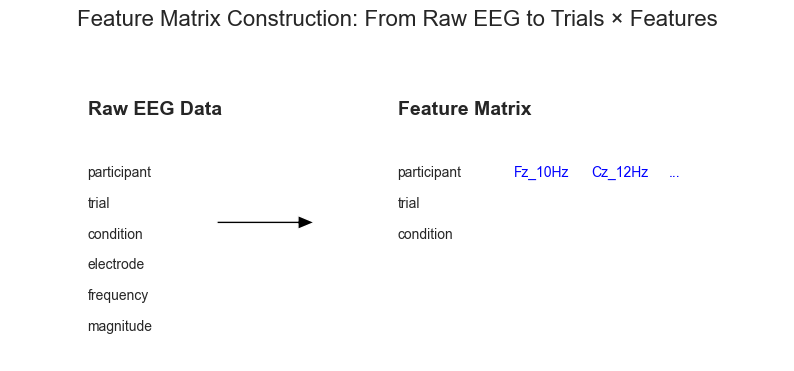

In [65]:
import matplotlib.pyplot as plt

def plot_feature_matrix_schematic():
    fig, ax = plt.subplots(figsize=(10, 4))
    # Draw input table
    ax.text(0.1, 0.8, "Raw EEG Data", fontsize=14, fontweight='bold')
    ax.text(0.1, 0.6, "participant", fontsize=10)
    ax.text(0.1, 0.5, "trial", fontsize=10)
    ax.text(0.1, 0.4, "condition", fontsize=10)
    ax.text(0.1, 0.3, "electrode", fontsize=10)
    ax.text(0.1, 0.2, "frequency", fontsize=10)
    ax.text(0.1, 0.1, "magnitude", fontsize=10)
    ax.add_patch(plt.Rectangle((0.08, 0.05), 0.18, 0.78, fill=False, lw=2))

    # Arrow
    ax.annotate('', xy=(0.4, 0.45), xytext=(0.26, 0.45),
                arrowprops=dict(facecolor='black', shrink=0.05, width=2, headwidth=10))

    # Draw output table
    ax.text(0.5, 0.8, "Feature Matrix", fontsize=14, fontweight='bold')
    ax.text(0.5, 0.6, "participant", fontsize=10)
    ax.text(0.5, 0.5, "trial", fontsize=10)
    ax.text(0.5, 0.4, "condition", fontsize=10)
    ax.text(0.65, 0.6, "Fz_10Hz", fontsize=10, color='blue')
    ax.text(0.75, 0.6, "Cz_12Hz", fontsize=10, color='blue')
    ax.text(0.85, 0.6, "...", fontsize=10, color='blue')
    ax.add_patch(plt.Rectangle((0.48, 0.35), 0.45, 0.33, fill=False, lw=2))

    ax.set_axis_off()
    plt.title("Feature Matrix Construction: From Raw EEG to Trials × Features", fontsize=16, pad=20)
    plt.show()

plot_feature_matrix_schematic()

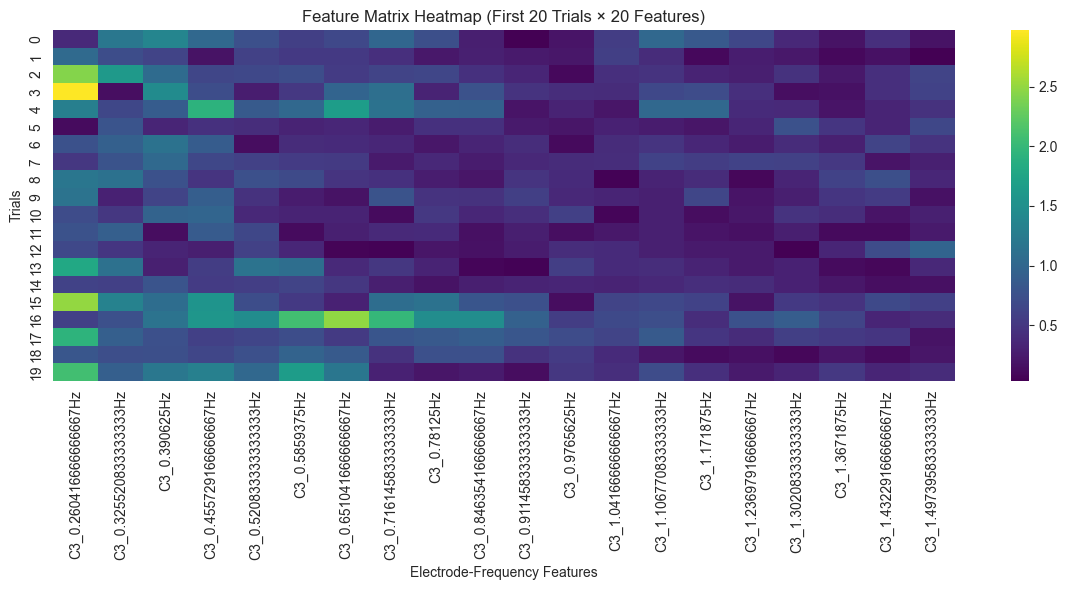

In [66]:
import seaborn as sns

def plot_feature_matrix_heatmap(feature_matrix, feature_cols, n_trials=20, n_features=20):
    data = feature_matrix[feature_cols[:n_features]].iloc[:n_trials]
    plt.figure(figsize=(12, 6))
    sns.heatmap(data, cmap='viridis', cbar=True)
    plt.xlabel("Electrode-Frequency Features")
    plt.ylabel("Trials")
    plt.title("Feature Matrix Heatmap (First 20 Trials × 20 Features)")
    plt.tight_layout()
    plt.show()

# Usage:
plot_feature_matrix_heatmap(feature_matrix, feature_cols)

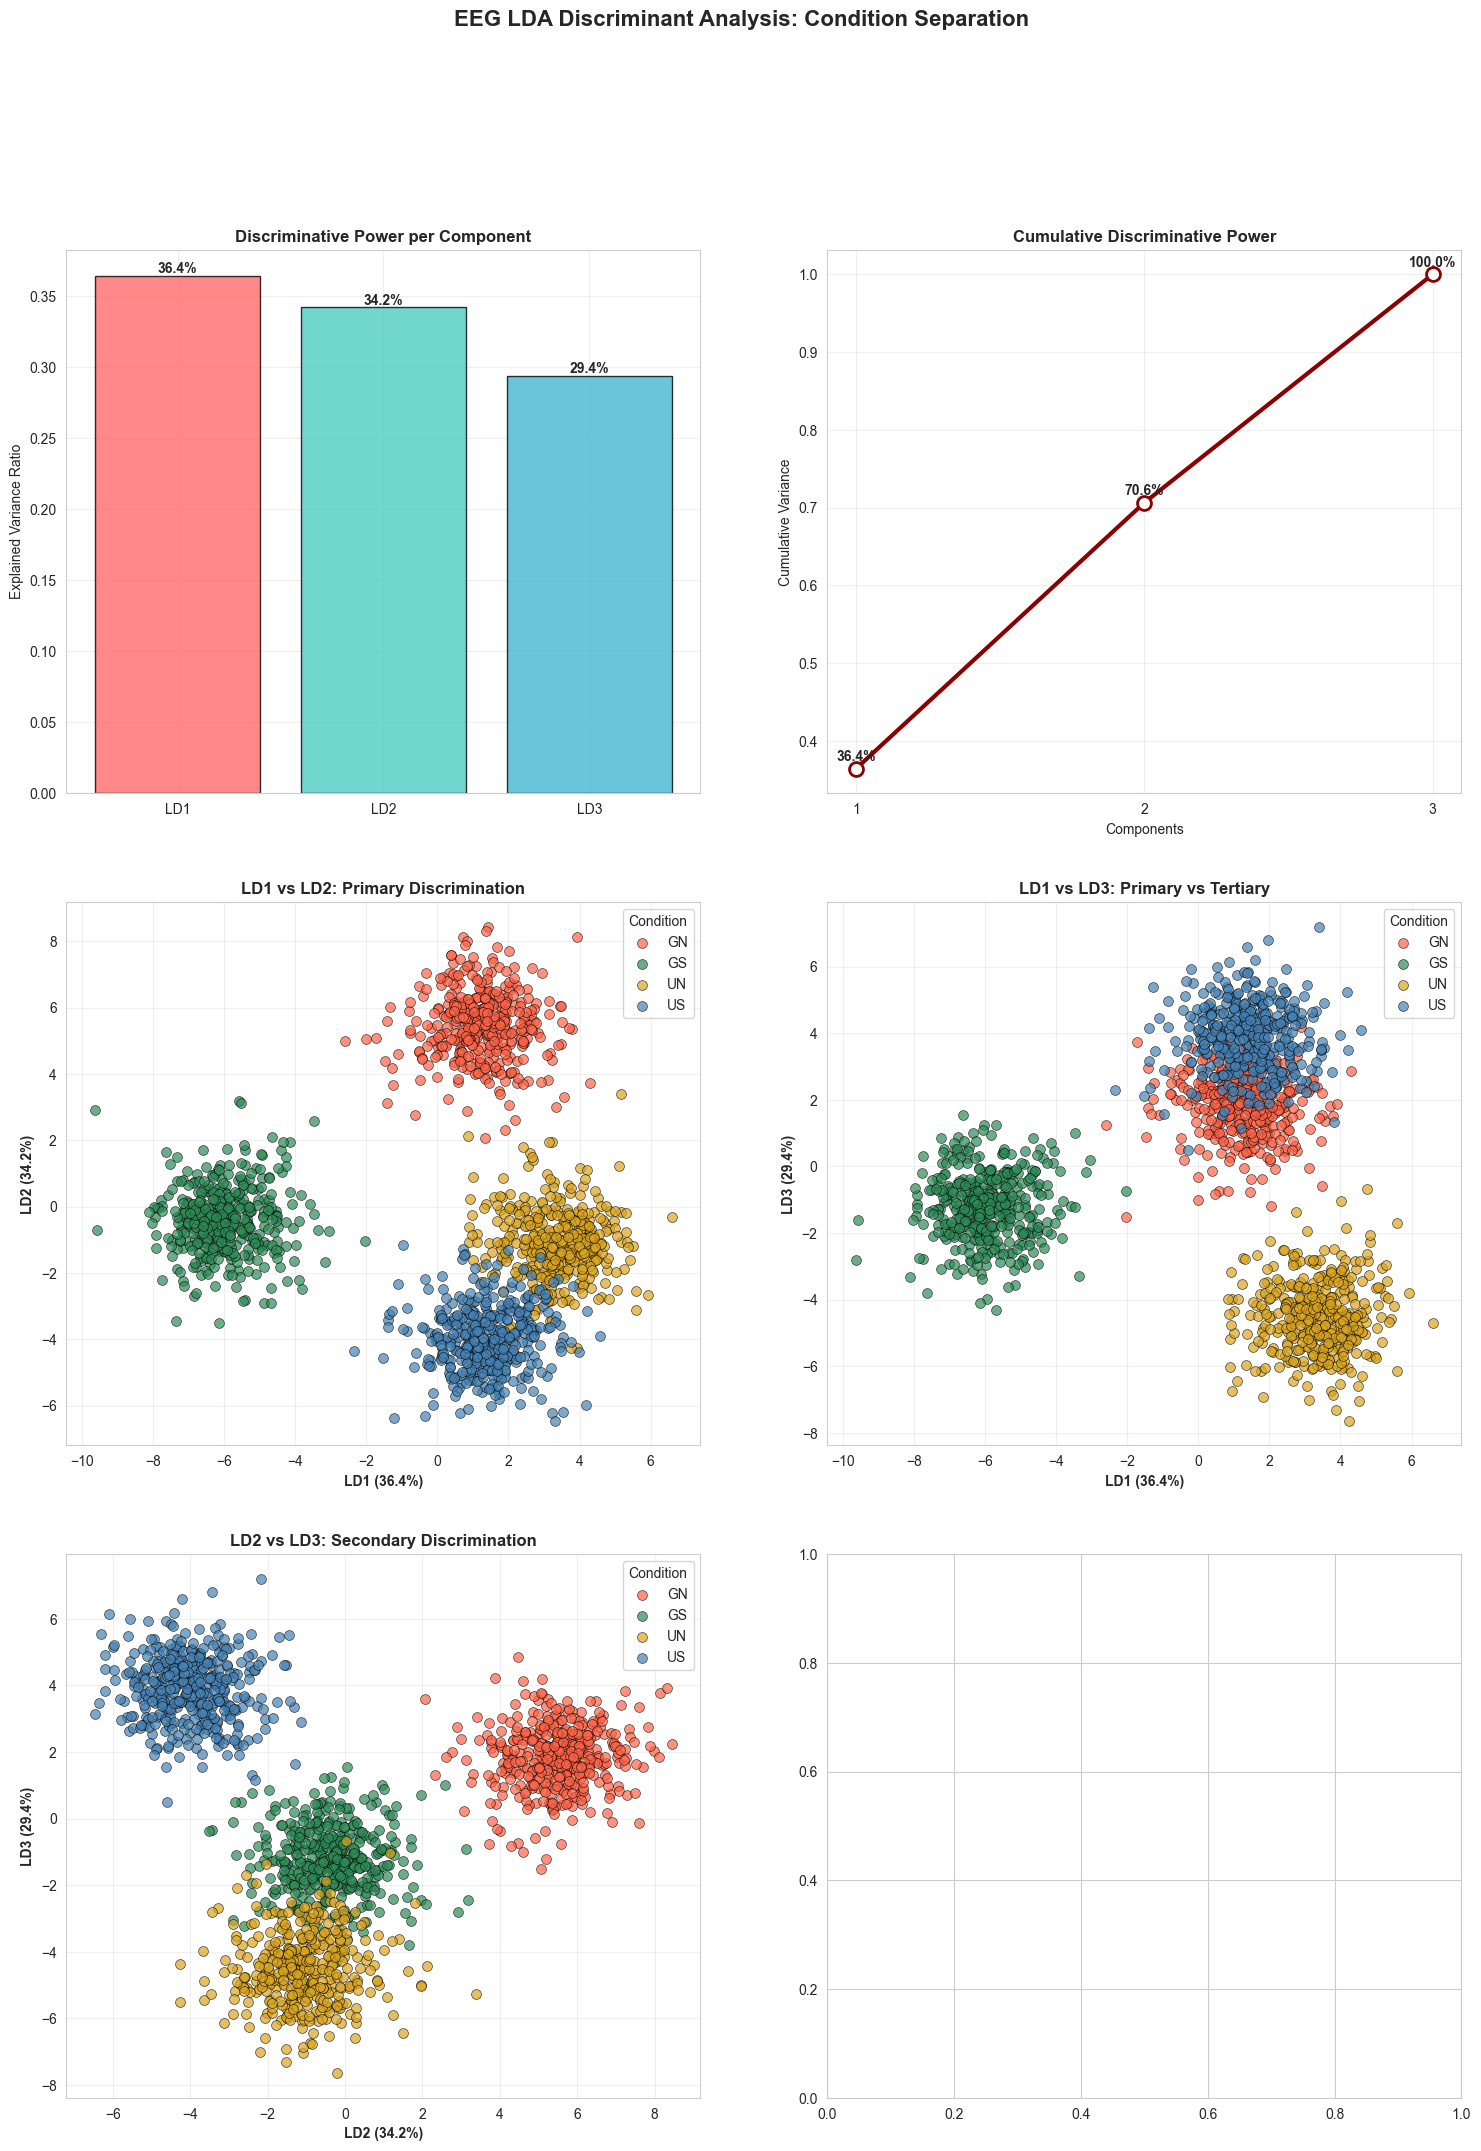

In [67]:
visualize_lda_components(lda_results, y_conditions)